## Setup

In [1]:
import os
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

import numpy as np
import pandas as pd
import random
import tensorflow as tf
import isuelogit as isl
import glob
import time

from sklearn import preprocessing
from sklearn.impute import SimpleImputer

In [2]:
# Path management
main_dir = str(Path(os.path.abspath('')).parents[1])
os.chdir(main_dir)
print('main dir:', main_dir)

isl.config.dirs['read_network_data'] = "input/network-data/fresno/"

main dir: /Users/pablo/github/nesuelogit


In [3]:
from pesuelogit.networks import load_k_shortest_paths, read_paths, build_fresno_network, sparsify_OD, read_OD
from pesuelogit.etl import get_design_tensor, get_y_tensor, data_curation, temporal_split, add_period_id, get_tensors_by_year
from pesuelogit.models import compute_rr

# Internal modules
from nesuelogit.models import NESUELOGIT, ODParameters, UtilityParameters, BPR, MLP, KernelConstraint, \
    GenerationParameters, train_val_split_by_links, train_kfold, compute_generated_trips, compute_generation_factors, \
    create_inference_model, compute_benchmark_metrics, PolynomialLayer, bpr_function
from nesuelogit.visualizations import  plot_predictive_performance, plot_metrics_kfold, plot_top_od_flows_periods, \
    plot_utility_parameters_periods, plot_rr_by_period, plot_rr_by_period_models, plot_total_trips_models, \
    plot_performance_functions, plot_flow_vs_traveltime, plot_flow_interaction_matrix, plot_parameters_kfold, plot_convergence_estimates, plot_parameters
from nesuelogit.metrics import mse, btcg_mse, mnrmse, mape, nrmse, r2_score, zscore, z2score
from nesuelogit.utils import read_paths

In [4]:
# Seed for reproducibility
_SEED = 2023
np.random.seed(_SEED)
random.seed(_SEED)
tf.random.set_seed(_SEED)

In [5]:
# To report global runtime
t0_global = time.time()

## Build Fresno network

In [6]:
fresno_network = build_fresno_network()

## Read OD matrix

In [7]:
read_OD(network=fresno_network, sparse=True)

q_historic = np.repeat(fresno_network.q.flatten()[np.newaxis, :], 6, axis=0)

Matrix Q (1789, 1789) read in 0.0[s] with sparse format
66266.3 trips were loaded among 6970 o-d pairs



## Read paths

In [8]:
#read_paths(network=fresno_network, update_incidence_matrices=True, filename='paths-fresno.csv')
read_paths(network=fresno_network, update_incidence_matrices=True, filename = 'paths-full-model-fresno.csv')

# For quick testing
# Q = fresno_network.load_OD(sparsify_OD(fresno_network.Q, prop_od_pairs=0.99))
# load_k_shortest_paths(network=fresno_network, k=2, update_incidence_matrices=True)

Paths were read and incidence matrix were built


## Read spatiotemporal data

In [9]:
folderpath = isl.config.dirs['read_network_data'] + 'links/spatiotemporal-data/'
df = pd.concat([pd.read_csv(file) for file in glob.glob(folderpath + "*link-data*")], axis=0)

df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
# Select data from Tuesday to Thursday
df = df[df['date'].dt.dayofweek.between(1, 3)]
# df = df[df['date'].dt.year == 2019]
# Select data from Wednesday only
#df = df[df['date'].dt.dayofweek.between(2, 2)]

# Select data from one day only
#df = df[df['date'] == "2019-10-02"]


In [10]:
# Add period id for timevarying estimation

period_feature = 'hour'

df['period'] = df['date'].astype(str) + '-' + df[period_feature].astype(str)
# df['period'] = df.period.map(hash)

df = add_period_id(df, period_feature='hour')

period_keys = df[[period_feature,'period_id']].drop_duplicates().reset_index().drop('index',axis =1).sort_values('hour')
print(period_keys)

    hour  period_id
11     6          0
12     7          1
13     8          2
14     9          3
0     10          4
1     11          5
2     12          6
3     13          7
4     14          8
5     15          9
6     16         10
7     17         11
8     18         12
9     19         13
10    20         14


In [11]:
df.head()

link_key  observed  counts  capacity [veh]  tt_ff [min]   
0     (0, 1621, '0')         0     NaN          1800.0        0.098  \
1  (1239, 1630, '0')         0     NaN             inf        0.000   
2    (228, 192, '0')         1  1667.0          2400.0        0.110   
3  (1243, 1631, '0')         0     NaN             inf        0.000   
4  (1244, 1632, '0')         0     NaN             inf        0.000   

   speed_ff[mi/hr]      inrix_id  pems_ids link_type   id  ...  median_age   
0               45  1.626616e+09        []     LWRLK    1  ...        31.1  \
1            99999           NaN        []     DMDLK  565  ...         0.0   
2               65  1.626659e+09  [602350]     LWRLK  564  ...        16.6   
3            99999           NaN        []     DMDLK  563  ...         0.0   
4            99999           NaN        []     DMDLK  562  ...         0.0   

   incidents  bus_stops  intersections       date  hour  tf_inrix  year   
0          0          0              1 2019-10-01    10     0.221  2019  \
1          0          0              0 2019-10-01    10     0.000  2019   
2          0          0              0 2019-10-01    10     0.112  2019   
3          0          0              0 2019-10-01    10     0.000  2019   
4          0          0              0 2019-10-01    10     0.000  2019   

          period  period_id  
0  2019-10-01-10          4  
1  2019-10-01-10          4  
2  2019-10-01-10          4  
3  2019-10-01-10          4  
4  2019-10-01-10          4  

[5 rows x 43 columns]

In [12]:
# Units in miles per hour
df[['speed_ref_avg','speed_hist_avg','speed_max']].describe()

speed_ref_avg  speed_hist_avg     speed_max
count   1.013460e+06    1.009583e+06  1.013460e+06
mean    1.924470e+01    1.767589e+01  2.051278e+01
std     1.982261e+01    1.909664e+01  2.140424e+01
min     0.000000e+00    0.000000e+00  0.000000e+00
25%     0.000000e+00    0.000000e+00  0.000000e+00
50%     2.112700e+01    1.755400e+01  2.112700e+01
75%     2.796200e+01    2.547600e+01  3.106900e+01
max     6.772900e+01    7.891400e+01  8.388500e+01

In [13]:
df.columns

Index(['link_key', 'observed', 'counts', 'capacity [veh]', 'tt_ff [min]',
       'speed_ff[mi/hr]', 'inrix_id', 'pems_ids', 'link_type', 'id', 'rhoj',
       'lane', 'ff_speed', 'length', 'alpha', 'beta', 'tf', 'k', 'inrix_id.1',
       'speed_avg', 'speed_ref_avg', 'speed_hist_avg', 'tt_avg', 'speed_max',
       'speed_sd', 'speed_cv', 'speed_hist_sd', 'speed_ref_sd', 'tt_sd',
       'tt_var', 'tt_cv', 'road_closures', 'median_inc', 'median_age',
       'incidents', 'bus_stops', 'intersections', 'date', 'hour', 'tf_inrix',
       'year', 'period', 'period_id'],
      dtype='object')

## Data curation

In [14]:
df['tt_ff'] = np.where(df['link_type'] != 'LWRLK', 0,df['length']/df['speed_ref_avg'])
df.loc[(df.link_type == "LWRLK") & (df.speed_ref_avg == 0),'tt_ff'] = float('nan')

df['tt_avg'] = np.where(df['link_type'] != 'LWRLK', 0,df['length']/df['speed_hist_avg'])
df.loc[(df.link_type == "LWRLK") & (df.speed_hist_avg == 0),'tt_avg'] = float('nan')

tt_sd_adj = df.groupby(['period_id','link_key'])[['tt_avg']].std().reset_index().rename(columns = {'tt_avg': 'tt_sd_adj'})

df = df.merge(tt_sd_adj, on = ['period_id','link_key'])

df = data_curation(df)

df['tt_sd'] = df['tt_sd_adj']

In [15]:
# Units of travel time features are converted from hours to minutes
df['tt_sd'] = df['tt_sd']*60
df['tt_avg'] = df['tt_avg']*60
df['tt_ff'] = df['tt_ff']*60

In [16]:
df[['speed_ref_avg','speed_hist_avg', 'tt_ff', 'tt_avg','tt_sd_adj']].describe()

speed_ref_avg  speed_hist_avg         tt_ff         tt_avg   
count   1.013460e+06    1.009583e+06  1.013460e+06  887813.000000  \
mean    1.924470e+01    1.767589e+01  2.038423e-01       0.219493   
std     1.982261e+01    1.909664e+01  2.610045e-01       0.262030   
min     0.000000e+00    0.000000e+00  0.000000e+00       0.000000   
25%     0.000000e+00    0.000000e+00  0.000000e+00       0.000000   
50%     2.112700e+01    1.755400e+01  1.497376e-01       0.167050   
75%     2.796200e+01    2.547600e+01  2.792397e-01       0.312986   
max     6.772900e+01    7.891400e+01  4.220601e+00       3.827439   

          tt_sd_adj  
count  1.013460e+06  
mean   3.022799e-04  
std    4.638521e-04  
min    0.000000e+00  
25%    0.000000e+00  
50%    1.856268e-04  
75%    4.248116e-04  
max    1.243267e-02

## Node data

In [17]:
node_data = pd.read_csv(isl.config.dirs['read_network_data'] + 'nodes/fresno-nodes-gis-data.csv')
node_data['population'] = node_data['pop_tract']#/node_data['nodes_tract']
#TODO: Compute area of each census tract and normalize number of stops for that
# node_data['bus_stops'] = node_data['stops_tract']/node_data['pop_tract']
node_data['bus_stops'] = node_data['stops_tract']#/node_data['nodes_tract']
node_data['income'] = node_data['median_inc']

In [18]:
features_generation = ['population','income', 'bus_stops']

node_data = node_data[['key','type'] + features_generation]

imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_mean.fit(node_data[features_generation])
node_data[features_generation] = imp_mean.transform(node_data[features_generation])

scaler = preprocessing.StandardScaler().fit(node_data[features_generation].values)
# scaler = preprocessing.MinMaxScaler().fit(node_data[features_generation].values)
node_data[features_generation] = scaler.transform(node_data[features_generation].values)

## Utility function

In [19]:
_FEATURES_Z = ['tt_sd', 'median_inc', 'incidents', 'bus_stops', 'intersections']
# _FEATURES_Z = ['tt_sd']
# _FEATURES_Z = []

## Data processing

In [20]:
n_links = len(fresno_network.links)
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df['year'] = df.date.dt.year
X, Y = {}, {}

In [21]:
df.query('year == 2019')[['counts', 'tt_ff', 'tt_avg', 'tf_inrix', 'tt_sd']].describe()

counts          tt_ff         tt_avg       tf_inrix   
count  31624.000000  542925.000000  468303.000000  542925.000000  \
mean    1761.140959       0.204903       0.221931       0.200169   
std      770.228931       0.262226       0.266852       0.228208   
min        1.000000       0.000000       0.000000       0.000000   
25%     1249.000000       0.000000       0.000000       0.000000   
50%     1686.000000       0.150455       0.168820       0.152000   
75%     2162.450000       0.282111       0.318261       0.280000   
max     4807.000000       4.220601       3.827439       2.302000   

               tt_sd  
count  542925.000000  
mean        0.018137  
std         0.027831  
min         0.000000  
25%         0.000000  
50%         0.011138  
75%         0.025489  
max         0.745960

In [22]:
df.query('year == 2020')[['counts', 'tt_ff', 'tt_avg', 'tf_inrix', 'tt_sd']].describe()

counts          tt_ff         tt_avg       tf_inrix   
count  27472.000000  470535.000000  419510.000000  470535.000000  \
mean    1605.127777       0.202618       0.216770       0.198494   
std      743.713869       0.259583       0.256512       0.226003   
min        6.000000       0.000000       0.000000       0.000000   
25%     1108.450000       0.000000       0.000000       0.000000   
50%     1528.900000       0.149437       0.165341       0.150000   
75%     1978.000000       0.274658       0.306717       0.273000   
max     4766.000000       4.220601       3.274444       2.113000   

               tt_sd  
count  470535.000000  
mean        0.018137  
std         0.027831  
min         0.000000  
25%         0.000000  
50%         0.011138  
75%         0.025489  
max         0.745960

In [23]:
# Set free flow travel times
tt_ff_links = df.groupby('link_key')['tt_ff'].min()
for link in fresno_network.links:
    fresno_network.links_dict[link.key].performance_function.tf = float(tt_ff_links[tt_ff_links.index==str(link.key)].iloc[0])

In [24]:
# This correlation should be positive
df[['counts','tt_avg']].corr()

counts    tt_avg
counts  1.000000  0.055122
tt_avg  0.055122  1.000000

## EDA

In [25]:
# To check that there is a balanced amount of observations per date
obs_date = df.groupby('date')['hour'].count()

In [26]:
# Stats by date
df.groupby('date')[['speed_sd','speed_avg', 'counts']].mean().assign(total_obs = obs_date)

speed_sd  speed_avg       counts  total_obs
date                                                   
2019-10-01  1.731787  17.175187  1770.335035      36195
2019-10-02  1.760109  17.169768  1746.651824      36195
2019-10-03  1.754288  17.092304  1785.115209      36195
2019-10-08  1.847060  18.165569  1747.732955      36195
2019-10-09  1.917923  18.137042  1756.834846      36195
2019-10-10  1.830232  18.107925  1793.512340      36195
2019-10-15  1.831527  18.114384  1750.339155      36195
2019-10-16  1.823680  18.162625  1760.170975      36195
2019-10-17  1.832219  18.080860  1775.411385      36195
2019-10-22  1.837839  18.175561  1738.314834      36195
2019-10-23  1.864443  18.222690  1753.243283      36195
2019-10-24  1.848827  18.184814  1746.626881      36195
2019-10-29  1.868430  18.167171  1731.246241      36195
2019-10-30  1.816364  18.109232  1757.581055      36195
2019-10-31  1.882446  18.128430  1804.595108      36195
2020-10-01  1.290377  19.579215  1616.266052      36195
2020-10-06  1.365919  19.709670  1581.200095      36195
2020-10-07  1.327017  19.927088  1587.425957      36195
2020-10-08  1.344382  19.969943  1604.360618      36195
2020-10-13  1.311842  19.626350  1607.663262      36195
2020-10-14  1.300075  19.558364  1613.399054      36195
2020-10-15  1.331493  19.621633  1637.123641      36195
2020-10-20  1.353743  19.597736  1599.044113      36195
2020-10-21  1.325694  19.501768  1587.235083      36195
2020-10-22  1.334320  19.591921  1628.075697      36195
2020-10-27  1.309348  19.573460  1583.478061      36195
2020-10-28  1.324270  19.646064  1593.821986      36195
2020-10-29  1.336212  19.557279  1627.548269      36195

### Link attributes

In [27]:
df[_FEATURES_Z].describe()

tt_sd    median_inc     incidents     bus_stops  intersections
count  1.013460e+06  1.013460e+06  1.013460e+06  1.013460e+06   1.013460e+06
mean   1.813680e-02  2.621913e+01  7.441093e-01  1.500207e-01   8.765023e-01
std    2.783112e-02  2.135738e+01  3.193143e+00  4.411927e-01   1.319496e+00
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   0.000000e+00
25%    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   0.000000e+00
50%    1.113761e-02  2.482100e+01  0.000000e+00  0.000000e+00   0.000000e+00
75%    2.548870e-02  4.168100e+01  0.000000e+00  0.000000e+00   1.000000e+00
max    7.459602e-01  1.158930e+02  4.000000e+01  4.000000e+00   9.000000e+00

## Training and validation sets

In [28]:
_DTYPE = tf.float32

# Data between 4pm and 5pm to estimate LUE, ODLUE and ODLULPE models
X, Y = get_tensors_by_year(df[df.hour.isin([16])], features_Z = _FEATURES_Z, network = fresno_network)

# Hourly data DURING morning and afternoon peak hour windows (6 hour intervals) to estimate TVODLULPE
XT, YT = get_tensors_by_year(df[df.hour.isin([6,7,8, 15,16,17])], features_Z = _FEATURES_Z, network = fresno_network)

# Split in training and test sets
X_train, X_val, Y_train, Y_val = map(lambda x: tf.cast(x, dtype = _DTYPE), [X[2019], X[2020], Y[2019], Y[2020]])
XT_train, XT_val, YT_train, YT_val = map(lambda x: tf.cast(x, dtype = _DTYPE), [XT[2019], XT[2020], YT[2019], YT[2020]])

In [29]:
XT[2019]

<tf.Tensor: shape=(90, 2413, 6), dtype=float64, numpy=
array([[[ 0.0175, 93.828 ,  0.    ,  0.    ,  1.    ,  9.    ],
        [ 0.0418, 66.653 ,  2.    ,  0.    ,  0.    ,  9.    ],
        [ 0.0255, 66.653 ,  6.    ,  0.    ,  0.    ,  9.    ],
        ...,
        [ 0.0009, 30.543 ,  1.    ,  0.    ,  1.    ,  9.    ],
        [ 0.0007, 23.611 ,  6.    ,  0.    ,  2.    ,  9.    ],
        [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  9.    ]],

       [[ 0.0268, 93.828 ,  0.    ,  0.    ,  1.    , 10.    ],
        [ 0.035 , 66.653 ,  2.    ,  0.    ,  0.    , 10.    ],
        [ 0.0255, 66.653 ,  6.    ,  0.    ,  0.    , 10.    ],
        ...,
        [ 0.0009, 30.543 ,  1.    ,  0.    ,  1.    , 10.    ],
        [ 0.0005, 23.611 ,  6.    ,  0.    ,  2.    , 10.    ],
        [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    , 10.    ]],

       [[ 0.0305, 93.828 ,  0.    ,  0.    ,  1.    , 11.    ],
        [ 0.0422, 66.653 ,  2.    ,  0.    ,  0.    , 11.    ],
        [ 0.0255, 6

## Configuration

In [30]:
_LOSS_WEIGHTS ={'od': 0, 'traveltime': 1, 'flow': 1, 'equilibrium': 1}
_EQUILIBRIUM_STAGE = True
_ALTERNATING_OPTIMIZATION = False

_LR = {'learning': 1e-1, 'equilibrium': 1e-2}

_BATCH_SIZE = 1 #16
_EPOCHS = {'learning': 30, 'equilibrium': 30}
# _EPOCHS = {'learning': 1, 'equilibrium': 1}
# _XTICKS_SPACING = 2
_XTICKS_SPACING = 5
_EPOCHS_PRINT_INTERVAL = {'learning':1, 'equilibrium':1}

_RELATIVE_GAP = 5e-2
# _RELATIVE_GAP = 1e-1

# _LOSS_METRIC  = mnrmse
# _LOSS_METRIC  = nrmse
# _LOSS_METRIC  = zscore
_LOSS_METRIC  = z2score

# With GPU
_OPTIMIZERS = {'learning': tf.keras.optimizers.legacy.Adam(learning_rate=_LR['learning']),
              'equilibrium': tf.keras.optimizers.legacy.Adam(learning_rate=_LR['equilibrium'])
              }

## Models

In [31]:
train_results_dfs = {}
val_results_dfs = {}
models = {}

In [32]:
def create_mlp(network, homogenous = False, diagonal = False, adjacency_constraint = True, poly_order = 4,
               alpha_prior = 0.15, beta_prior = 4, pretrain = False, dtype =_DTYPE, link_specific = True):

    return MLP(n_links=len(network.links),
               free_flow_traveltimes=[link.bpr.tf for link in network.links],
               capacities=[link.bpr.k for link in network.links],
               kernel_constraint=KernelConstraint(
                   link_keys=[(link.key[0], link.key[1]) for link in network.links],
                   dtype=dtype,
                   capacities=[link.bpr.k for link in network.links],
                   adjacency_constraint=adjacency_constraint,
                   free_flow_traveltimes=[link.bpr.tf for link in network.links],
                   diagonal= diagonal,
                   homogenous=homogenous,
                   bounds_clipping = [0,10],
                   min_diagonal_value = 1e-1
               ),
               trainable =True,
               polynomial_layer= PolynomialLayer(poly_order=poly_order,
                                                 trainable = True,
                                                 pretrain_weights=pretrain,
                                                 alpha_prior = alpha_prior, beta_prior=beta_prior,
                                                 kernel_constraint=tf.keras.constraints.NonNeg(),
                                                 link_specific = link_specific
                                                 ),
               # alpha_relu = 1e-1,
               alpha_relu = 0,
               depth=1,
               max_traveltime_factor = None,
               dtype=dtype)

def create_bpr(network, alpha_prior = 1, beta_prior = 1, dtype =_DTYPE):
    return BPR(keys=['alpha', 'beta'],
               # initial_values={'alpha': 0.15, 'beta': 4},
               # initial_values={'alpha': alpha_prior, 'beta': beta_prior}, # Consistent with MLP initialization
               initial_values={'alpha': alpha_prior * tf.ones(len(network.links), dtype = dtype),
                               'beta': beta_prior * tf.ones(len(network.links), dtype = dtype)},
               true_values={'alpha': 0.15, 'beta': 4},
               trainables={'alpha': True, 'beta':True},
               capacities = [link.bpr.k for link in network.links],
               free_flow_traveltimes =[link.bpr.tf for link in network.links],
               dtype = dtype
               )

def create_tvgodlulpe_model_fresno(network, dtype=_DTYPE, n_periods=1, features_Z=_FEATURES_Z, historic_g=None,
                                      performance_function=None, utility_parameters = None, od_parameters = None,
                                      generation_parameters = None, generation = True, od_trainable = False,
                                      utility_trainable = True, pretrain_generation_weights = True, generation_trainable = True):

    if utility_parameters is None:
        utility_parameters = UtilityParameters(features_Y=['tt'],
                                               features_Z=features_Z,
                                               # initial_values={
                                               #                 'tt': -10,
                                               #                 'tt_sd': -10, 'median_inc': 1,
                                               #                 'incidents': -1, 'bus_stops': -1, 'intersections': -1,
                                               #                 'psc_factor': 0,
                                               #                 'fixed_effect': np.zeros_like(network.links)},
                                               initial_values={
                                                   'tt': -3.0597,
                                                   'tt_sd': -3.2678, 'median_inc': 0,
                                                   'incidents': -4.5368, 'bus_stops': 0, 'intersections': -3.8788,
                                                   'psc_factor': 0,
                                                   'fixed_effect': np.zeros_like(network.links)},

                                               signs={'tt': '-', 'tt_sd': '-', 'median_inc': '+', 'incidents': '-',
                                                      'bus_stops': '-', 'intersections': '-'},
                                               trainables={'psc_factor': False, 'fixed_effect': utility_trainable,
                                                           'tt': utility_trainable, 'tt_sd': True, 'median_inc': True,
                                                           'incidents': True,
                                                           'bus_stops': True, 'intersections': True
                                                           },
                                               time_varying=True,
                                               dtype=dtype
                                               )

    if performance_function is None:
        # performance_function = create_bpr(network = network, dtype = dtype)
        performance_function = create_mlp(network = network, dtype = dtype)

    if generation_parameters is None and generation:
        generation_parameters = GenerationParameters(
            features_Z=['population', 'income', 'bus_stops'],
            keys=['fixed_effect_od', 'fixed_effect_origin', 'fixed_effect_destination'],
            initial_values={'income': 0, 'population': 0, 'bus_stops': 0,
                            # 'fixed_effect': historic_g[0]
                            'fixed_effect': historic_g
                            },
            signs={'income': '+', 'population': '+', 'bus_stops': '-'},
            trainables={'fixed_effect': generation_trainable,
                        'income': False, 'population': False, 'bus_stops': False,
                        # 'income': True, 'population': True, 'bus_stops': True,
                        'fixed_effect_origin': False, 'fixed_effect_destination': False, 'fixed_effect_od': generation_trainable
                        # 'fixed_effect_origin': False, 'fixed_effect_destination': generation_trainable, 'fixed_effect_od': False
                        },
            # trainables={'fixed_effect': True, 'income': True, 'population': True, 'bus_stops': True},
            # trainables={'fixed_effect': False, 'income': False, 'population': False, 'bus_stops': False},
            time_varying=True,
            # historic_g = od_parameters.compute_generated_trips(),
            historic_g= historic_g,
            pretrain_generation_weights=pretrain_generation_weights,
            dtype=dtype
        )

    if od_parameters is None:
        od_parameters = ODParameters(key='od',
                                     initial_values= q_historic,
                                     historic_values={10: network.q.flatten()},
                                     # total_trips={0: 1e5, 1: 1e5, 2: 1e5, 9: 1e5, 10: 1e5, 11: 1e5},
                                     ods=network.ods,
                                     n_periods=n_periods,
                                     time_varying=True,
                                     trainable= od_trainable,
                                     )

    model = NESUELOGIT(
        key='tvgodlulpe',
        network=network,
        dtype=dtype,
        utility=utility_parameters,
        performance_function=performance_function,
        od=od_parameters,
        generation=generation_parameters,
        n_periods=n_periods
    )

    return model, {'utility_parameters': utility_parameters, 'generation_parameters': generation_parameters,
                   'od_parameters': od_parameters, 'performance_function': performance_function}

In [33]:
# Total trips tvodlulpe pesuelogit:
# Epoch 0: 6.6e+04 6.6e+04 6.6e+04 6.6e+04 6.6e+04 6.6e+04
# Final epoch: 6.4e+04 6.6e+04 6.3e+04 7.8e+04 7.9e+04 7.9e+04
# Growth factor captures the difference between the reference OD at epoch 0 and the estimated OD.
growth_factor = 7.9/6.6
#growth_factor = 1

generation_factors = compute_generation_factors(period_column=XT_train[:, :, -1, None].numpy(),
                                                              flow_column=YT_train[:,:,1, None].numpy(), reference_period=10)

n_periods = len(np.unique(XT_train[:, :, -1].numpy().flatten()))

generated_trips = growth_factor*generation_factors.values[:,np.newaxis]*compute_generated_trips(q = q_historic, ods= fresno_network.ods)

### Benchmark (TVODLULPE)

In [34]:

# To report runtime
t0 = time.time()

models['tvodlulpe'], _ = create_tvgodlulpe_model_fresno(
    n_periods= n_periods, network = fresno_network,
    performance_function = create_bpr(network = fresno_network, dtype = _DTYPE, alpha_prior = 0.9327, beta_prior = 4.1017),
    od_parameters = ODParameters(key='od',
                                 #initial_values= generation_factors.values[:,np.newaxis]*tntp_network.q.flatten(),
                                 initial_values = tf.stack(q_historic),
                                 historic_values={10: q_historic[0].flatten()},
                                 ods=fresno_network.ods,
                                 n_periods=n_periods,
                                 time_varying=True,
                                 trainable=True),
    generation = False,
    utility_trainable = True
)

models['tvodlulpe'].key = 'tvodlulpe'

In [35]:
train_results_dfs['tvodlulpe'], val_results_dfs['tvodlulpe'] = models['tvodlulpe'].fit(
    XT_train, YT_train, XT_val, YT_val,
    optimizers= {'learning': tf.keras.optimizers.legacy.Adam(learning_rate=_LR['learning']),
                 'equilibrium': tf.keras.optimizers.legacy.Adam(learning_rate=_LR['equilibrium'])},
    node_data=node_data,
    batch_size=_BATCH_SIZE,
    loss_weights=_LOSS_WEIGHTS,
    loss_metric= _LOSS_METRIC,
    equilibrium_stage=_EQUILIBRIUM_STAGE,
    alternating_optimization=_ALTERNATING_OPTIMIZATION,
    pretrain_link_flows = True,
    threshold_relative_gap=_RELATIVE_GAP,
    epochs_print_interval=_EPOCHS_PRINT_INTERVAL,
    epochs=_EPOCHS)

print(f'runtime: {time.time()-t0:0.1f} [s]')

# Save model weights for prediction analyses
models['tvodlulpe'].save_weights(models['tvodlulpe']._filepath_weights)
print(f"\nModel weights were saved at '{models['tvodlulpe']._filepath_weights}'")


Model training

Link flows and travel times were pretrained with single pass of traffic assignment
Benchmark metrics using mean in training data to make predictions in the validation set: 


    component    value metric
0        flow       57   mape
1  traveltime       55   mape
0        flow    6e+05    mse
1  traveltime    0.063    mse
0        flow   -0.057     r2
1  traveltime -0.00022     r2

hyperparameters loss function: {'od': 0, 'traveltime': 1, 'flow': 1, 'equilibrium': 1}

number of periods: 6, batch size: 1, threshold relative gap: 0.05
training set -> timepoints: 90, obs [t x]: [2073.  140.], coverage [t x]: [0.86 0.06]
validation set -> timepoints: 78, obs [t x]: [2139.  140.], coverage [t x]: [0.89 0.06]

Learning stage: 30 epochs

0/60: train mse=6.2e+05, train mse traveltime=1.3, train mape traveltime=121.8 train mse flow=1.7e+06, train mape flow=97.8, val mse=7.4e+05, val mse traveltime=1.3, val mape traveltime=122.3 val mse flow=1.9e+06, val mape flow=93.8, theta =

In [36]:
# models['tvodlulpe'].build()
# models['tvodlulpe'].load_weights("output/models/230623133023_tvgodlulpe_fresno.h5")
# models['tvodlulpe'].update_predictions(XT_train, update_period_dict = True)

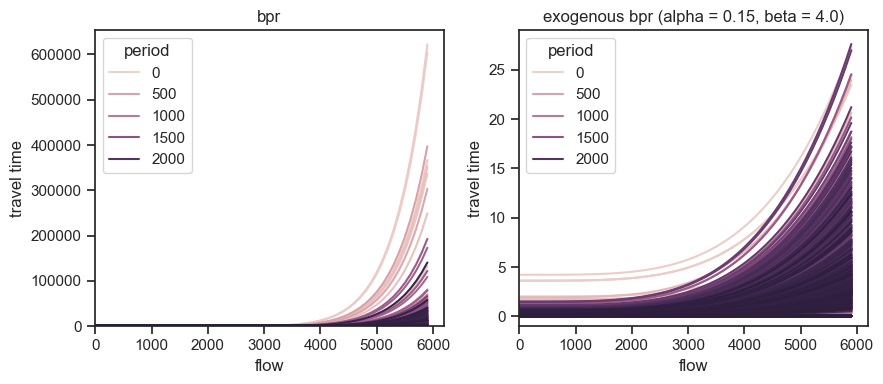

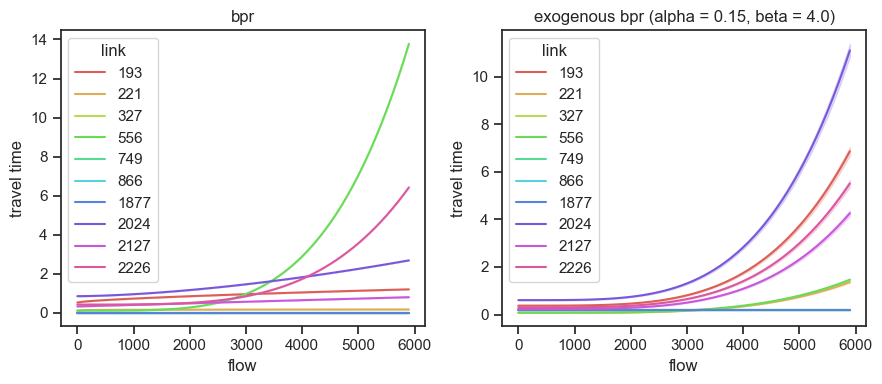

In [37]:
flow_range = range(0,6000,100)
sharey = False

fig, axs = plot_performance_functions(model = models['tvodlulpe'],
                                      network = fresno_network,
                                      marginal = False,
                                      #alpha=models['tvodlulpe'].performance_function.alpha,
                                      #beta=models['tvodlulpe'].performance_function.beta,
                                      alpha=0.15*np.ones(fresno_network.get_n_links()),
                                      beta=4*np.ones(fresno_network.get_n_links()),
                                      sharey = sharey,
                                      flow_range = flow_range
                                      # selected_links = np.random.choice(range(tntp_network.get_n_links()), 10, replace=False)
                                      )

for ax in axs.reshape(-1):
    ax.set_xlim(xmin=-10)
    ax.set_ylim(ymin=-1)
    ax.legend(loc='upper left', title = 'period')

plt.savefig('output/figures/results/fresno-comparison-all-link-performance-functions-tvodlulpe.png')

plt.show()

selected_links = np.random.choice(range(fresno_network.get_n_links()), 10, replace=False)

plot_performance_functions(model=models['tvodlulpe'],
                           network=fresno_network,
                           marginal=True,
                           # alpha=models['tvodlulpe'].performance_function.alpha,
                           # beta=models['tvodlulpe'].performance_function.beta,
                           alpha=0.15*np.ones(fresno_network.get_n_links()),
                           beta=4*np.ones(fresno_network.get_n_links()),
                           selected_links = selected_links,
                           palette = sns.color_palette("hls", len(selected_links)),
                           sharey = sharey,
                           flow_range = flow_range
                           )

plt.show()


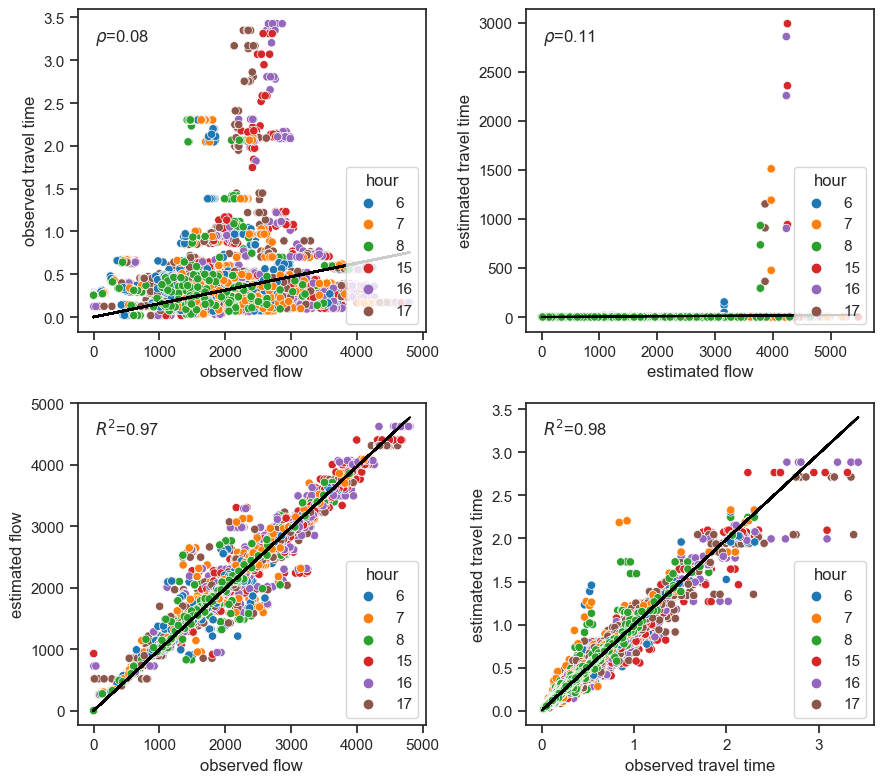

In [38]:
fig, axs = plot_flow_vs_traveltime(model = models['tvodlulpe'],
                        observed_traveltime=models['tvodlulpe'].mask_observed_traveltime(YT_train[:, :, 0]),
                        observed_flow= models['tvodlulpe'].mask_observed_flow(YT_train[:,:,1]),
                        period_col = pd.DataFrame({'period': list(XT_train[:, :, -1].numpy().astype(int).flatten())})['period'].map(dict(zip(period_keys.period_id, period_keys.hour))).values.flatten(),
                        hour_label=True,
                        # scatter_kws={"color": sns.color_palette("deep")[0], 's':4, 'alpha': 1}, line_kws={"color": "black"},
                        all_metrics = False
                        )

for ax in axs.reshape(-1):
    ax.legend(loc='lower right', title = 'hour')

plt.show()

(<Figure size 550x500 with 1 Axes>, <Axes: xlabel='epoch', ylabel='mape (%)'>)

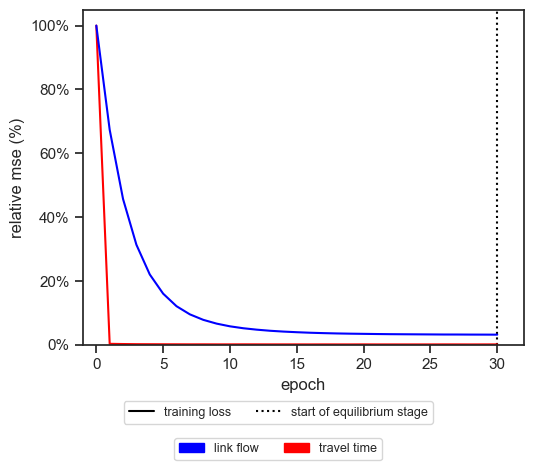

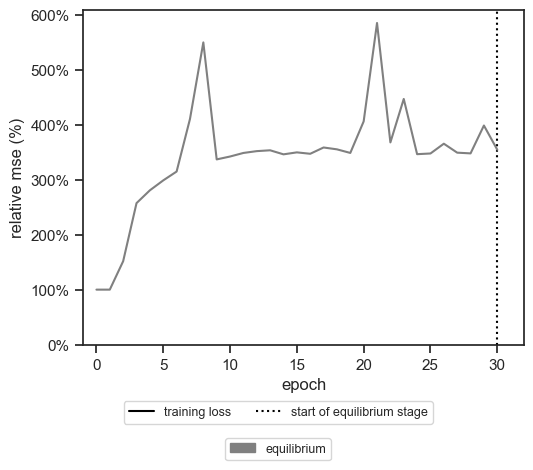

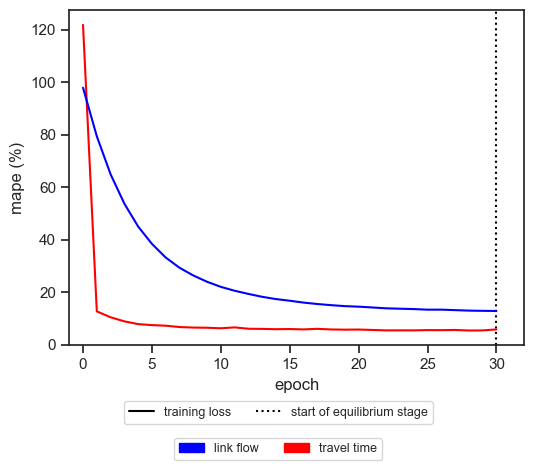

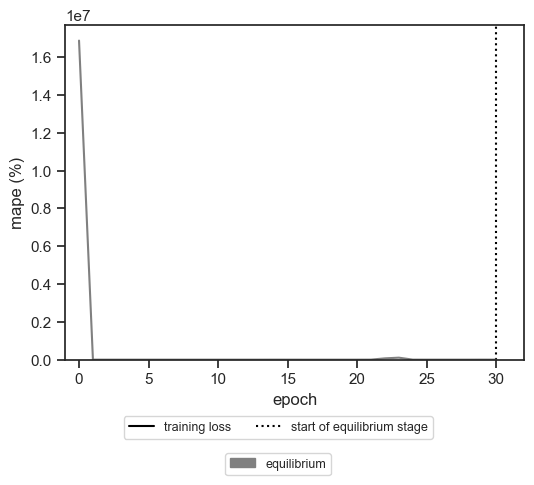

In [39]:
plot_predictive_performance(train_losses=train_results_dfs['tvodlulpe'], val_losses=val_results_dfs['tvodlulpe'],
                            xticks_spacing=_XTICKS_SPACING, show_validation=False,
                            # curves=['travel time', 'link flow'],
                            curves=['travel time', 'link flow'],
                            epochs_end_learning_stage = _EPOCHS['learning']
                            )

plt.savefig('output/figures/results/fresno-relative-mse-tvodlulpe.png')

plot_predictive_performance(train_losses=train_results_dfs['tvodlulpe'], val_losses=val_results_dfs['tvodlulpe'],
                            xticks_spacing=_XTICKS_SPACING, show_validation=False,
                            curves=['equilibrium'],
                            epochs_end_learning_stage=_EPOCHS['learning'])

plot_predictive_performance(train_losses=train_results_dfs['tvodlulpe'], val_losses=val_results_dfs['tvodlulpe'],
                            xticks_spacing=_XTICKS_SPACING, show_validation=False,
                            curves=['travel time', 'link flow'],
                            epochs_end_learning_stage=_EPOCHS['learning'], prefix_metric='mape',
                            yaxis_label='mape (%)')

plt.savefig('output/figures/results/fresno-mape-tvodlulpe.png')

plot_predictive_performance(train_losses=train_results_dfs['tvodlulpe'], val_losses=val_results_dfs['tvodlulpe'],
                            xticks_spacing=_XTICKS_SPACING, show_validation=False,
                            epochs_end_learning_stage=_EPOCHS['learning'], prefix_metric='mape',
                            curves=['equilibrium'],
                            yaxis_label='mape (%)')

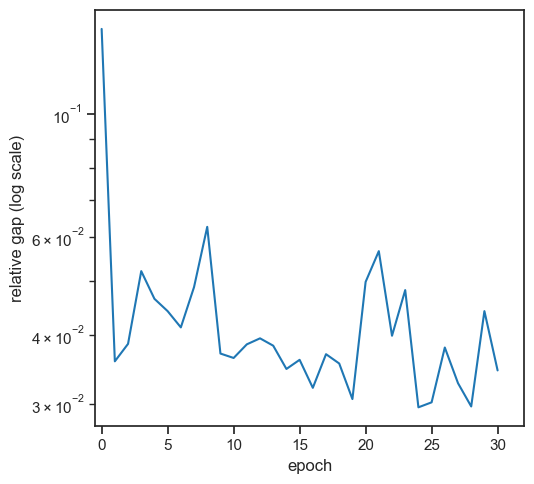

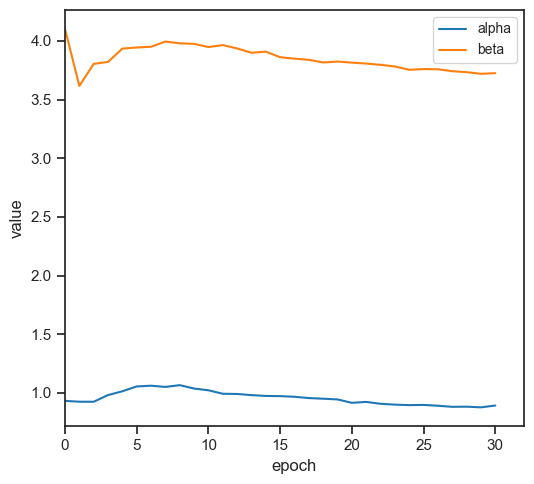

In [40]:
fig, ax = plot_convergence_estimates(
    estimates=train_results_dfs['tvodlulpe'].assign(
        relative_gap=np.abs(train_results_dfs['tvodlulpe']['relative_gap']))[['epoch', 'relative_gap']],
    xticks_spacing=_XTICKS_SPACING)

#ax.set_ylim(ymin=1e-2, ymax = 5.5e-2)
#ax.set_ylim(ymin=1e-2)
ax.set_xlim(xmin=-0.5)
ax.set_yscale('log')
ax.set_ylabel('relative gap (log scale)')
ax.get_legend().remove()

plt.savefig('output/figures/results/fresno-relative-gap-tvodlulpe.png')

plt.show()

plot_convergence_estimates(estimates=train_results_dfs['tvodlulpe'][['epoch', 'alpha', 'beta']],
                           xticks_spacing=_XTICKS_SPACING)
plt.show()

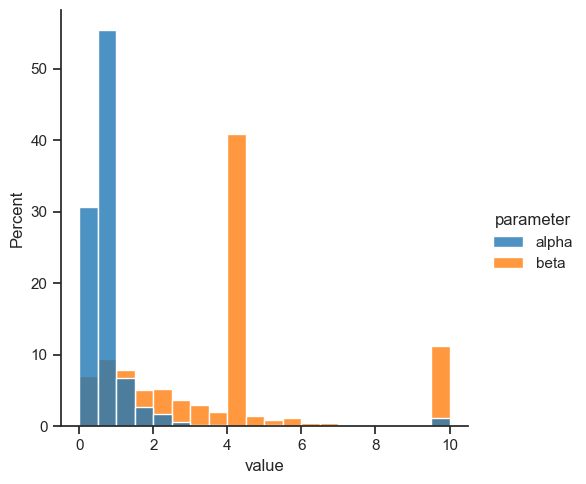

             tt     tt_sd  median_inc  incidents  bus_stops  intersections   
6-7   -2.691330 -1.115627         0.0  -4.477630   0.000000      -4.214572  \
7-8   -2.721493 -2.519286         0.0  -4.728908  -0.326997      -4.462020   
8-9   -3.023994 -3.575122         0.0  -5.041572  -0.184054      -4.765817   
15-16 -2.746538 -2.317832         0.0  -4.994182   0.000000      -4.629020   
16-17 -2.854111 -3.417571         0.0  -4.722504   0.000000      -4.605755   
17-18 -2.600173 -4.968421         0.0  -4.596395   0.000000      -4.506031   

       hour  
6-7       6  
7-8       7  
8-9       8  
15-16    15  
16-17    16  
17-18    17  


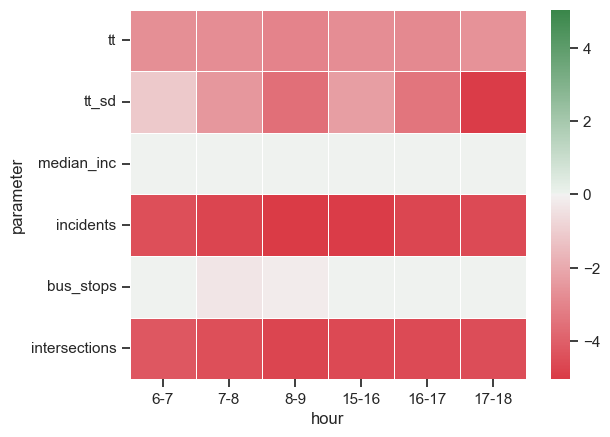

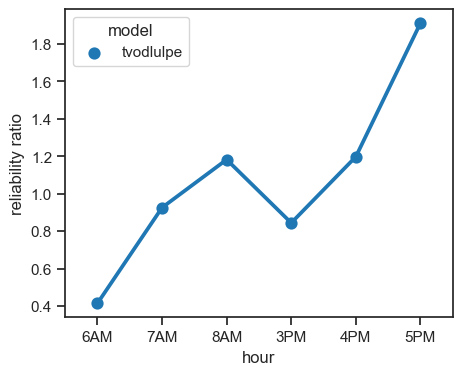

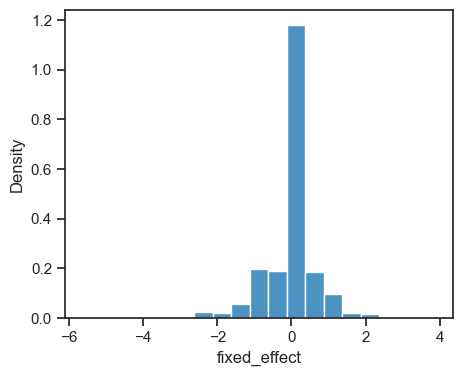

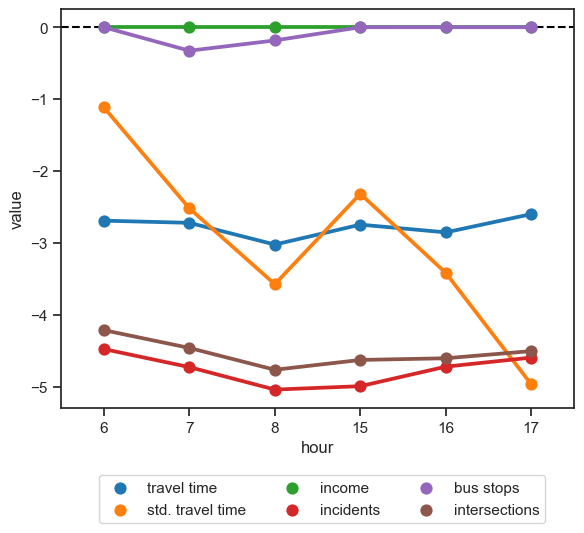

In [41]:
#sns.displot(plot_data, x="value", hue="parameter", multiple="stack", kind="hist", alpha=0.8, norm_hist=True)

plot_data = pd.melt(pd.DataFrame({'alpha': models['tvodlulpe'].performance_function.alpha,
                              'beta': models['tvodlulpe'].performance_function.beta}), var_name='parameter')

# fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (5,4))
# sns.histplot(plot_data, x="value", stat='density', hue="parameter", alpha =0.8, ax = ax, binwidth = 0.5)

sns.displot(plot_data, x="value", kind="hist", stat='percent', common_norm=False, hue = "parameter", alpha=0.8, facet_kws=dict(sharey=False, sharex = False), binwidth = 0.5)

plt.savefig('output/figures/results/fresno-distribution-link-performance-parameters-tvodlulpe.png')

plt.show()

# Compute utility parameters over time (heatmap) and value of travel time reliability (lineplot)
theta_df = plot_utility_parameters_periods(models['tvodlulpe'], period_keys = period_keys, period_feature='hour')

print(theta_df)
#print(theta_df.values)

plot_rr_by_period(models['tvodlulpe'],period_keys, model_key = 'tvodlulpe', period_feature='hour')

fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (5,4))
sns.histplot(pd.DataFrame({'fixed_effect': np.array(models['tvodlulpe'].fixed_effect)}), stat='density', x="fixed_effect", alpha=0.8, ax = ax, binwidth=0.5)
plt.show()

theta_df = plot_utility_parameters_periods(models['tvodlulpe'], period_keys=period_keys, period_feature='hour', plot = False).reset_index().\
    drop(['hour','index'], axis = 1).reset_index().rename(columns = {'index':'period'})

# theta_df = pd.melt(theta_df.assign(rr = theta_df.apply(compute_rr, axis=1)), id_vars = 'period', var_name = 'parameter').assign(group = 'utility').\
#     replace({'tt': 'travel time', 'tt_sd': 'std. travel time', 'rr': 'reliability ratio', 's': 'intersections', 'bus_stops': 'bus stops', 'median_inc': 'income'})

theta_df = pd.melt(theta_df, id_vars = 'period', var_name = 'parameter').assign(group = 'utility').\
    replace({'tt': 'travel time', 'tt_sd': 'std. travel time', 'rr': 'reliability ratio', 's': 'intersections', 'bus_stops': 'bus stops', 'median_inc': 'income'})

theta_df['hour'] = theta_df['period'].map({v:period_keys[period_keys.period_id == k]['hour'].iloc[0] for k,v in models['tvodlulpe'].period_dict.items()})

fig, axs = plot_parameters(df = theta_df, n_cols_legend = 3, figsize = (6,5.5), hour_label = True)

plt.axhline(0, linestyle ='dashed', color = 'black')

plt.savefig('output/figures/results/fresno-utility-periods-tvodlulpe.png')

plt.show()

(           historic_od         6AM          7AM         8AM          3PM   
 1618 175     1840.4001  947.518494  1034.644653  990.809265  1299.880005  \
      694     1182.4533  512.162964   571.378845  547.818359   743.577942   
 42   1617    1139.6952  506.058441   530.734131  404.469971   458.359680   
 693  1617    1077.8859  435.669434   435.944977  358.554504   415.945374   
 272  1614     598.5315    0.008031     0.005442    0.026522     0.000343   
 701  1629     577.9746  524.660889   473.554138  421.816345   572.404053   
 226  1651     472.3362  322.434631   333.739685  340.686279   458.383179   
 220  1688     446.1534  445.406342   429.889862  442.729401   451.398926   
 104  1693     430.1766  389.030273   411.732361  398.348633   423.132111   
 871  1679     428.9796  453.951874   440.557983  418.694458   415.861298   
 1615 88       426.7179   19.463482     2.386308    0.002710     2.559648   
 807  1650     418.2822  262.825958   218.190613  176.210724   458.231201   

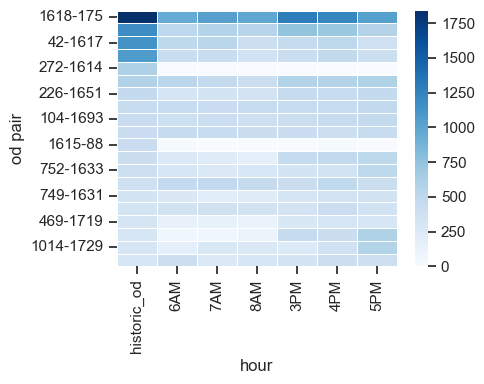

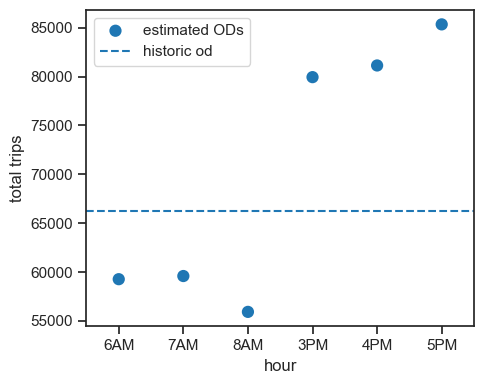

In [42]:
# Plot heatmap with flows of top od pairs
plot_top_od_flows_periods(models['tvodlulpe'],
                          historic_od= fresno_network.q.flatten(),
                          period_keys = period_keys,
                          period_feature='hour', top_k=20)

In [43]:
print(f"theta = "
      f"{dict(zip(models['tvodlulpe'].utility.true_values.keys(), list(np.mean(models['tvodlulpe'].theta.numpy(), axis=0))))}")

print(f"alpha = {np.mean(models['tvodlulpe'].performance_function.alpha): 0.2f}, "
          f"beta  = {np.mean(models['tvodlulpe'].performance_function.beta): 0.2f}")

print(f"Avg abs diff of observed and estimated OD: "
      f"{np.mean(np.abs(models['tvodlulpe'].q - fresno_network.q.flatten())): 0.2f}")

print(f"Avg observed OD: {np.mean(np.abs(fresno_network.q.flatten())): 0.2f}")

theta = {'tt': -2.77294, 'tt_sd': -2.9856431, 'median_inc': 0.0, 'incidents': -4.760198, 'bus_stops': -0.08517504, 'intersections': -4.530536}
alpha =  0.89, beta  =  3.72
Avg abs diff of observed and estimated OD:  9.24
Avg observed OD:  9.51


In [44]:
metrics_df = models['tvodlulpe'].compute_loss_metrics(metrics={'mape': mape, 'mse': mse, 'r2': r2_score},
                                                      X=XT_train, Y=YT_train).assign(dataset='training')
metrics_df = pd.concat([metrics_df,
                        models['tvodlulpe'].compute_loss_metrics(metrics={'mape': mape, 'mse': mse, 'r2': r2_score},
                                                                 X=XT_val, Y=YT_val).assign(dataset='validation'),
                        compute_benchmark_metrics(metrics={'mape': mape, 'mse': mse, 'r2': r2_score}, Y_ref=YT_train,
                                                  Y=YT_val).assign(
                            dataset='benchmark')
                        ])

with pd.option_context('display.float_format', '{:0.3g}'.format):
    print(pd.pivot(metrics_df, index=['component', 'dataset'], columns=['metric'])['value'])


metric                     mape      mse       r2
component   dataset                              
equilibrium training       61.2 1.52e+04    0.978
            validation 2.46e+13 4.47e+04    0.935
flow        benchmark      56.9 5.99e+05  -0.0567
            training       12.6 4.61e+04    0.924
            validation     19.4 1.56e+05    0.736
traveltime  benchmark      55.2   0.0626 -0.00022
            training       6.37  0.00192    0.971
            validation     10.7  0.00563    0.908


### TVGODLULPE

In [45]:
print('\ntvgodlulpe: Time specific utility and generation, and link specific parameters for performance functions')

# To report runtime
t0 = time.time()

models['tvgodlulpe'], _ = create_tvgodlulpe_model_fresno(
    n_periods = n_periods,
    network = fresno_network,
    performance_function = create_mlp(network = fresno_network,
                                      poly_order = 4, pretrain = False, link_specific = False),
    historic_g= generated_trips,
    generation = True,
    generation_trainable = True,
    utility_trainable = True)

models['tvgodlulpe'].key = 'tvgodlulpe'


tvgodlulpe: Time specific utility and generation, and link specific parameters for performance functions


In [46]:
# May remove validation set for faster training.
train_results_dfs['tvgodlulpe'], val_results_dfs['tvgodlulpe'] = models['tvgodlulpe'].fit(
    XT_train, YT_train, XT_val, YT_val,
    node_data=node_data,
    optimizers= {'learning': tf.keras.optimizers.legacy.Adam(learning_rate=_LR['learning']),
                 'equilibrium': tf.keras.optimizers.legacy.Adam(learning_rate=_LR['equilibrium'])},
    batch_size=_BATCH_SIZE,
    # batch_size=None,
    loss_weights= _LOSS_WEIGHTS,
    loss_metric=_LOSS_METRIC,
    equilibrium_stage=_EQUILIBRIUM_STAGE,
    alternating_optimization=_ALTERNATING_OPTIMIZATION,
    pretrain_link_flows = True,
    threshold_relative_gap=_RELATIVE_GAP,
    epochs_print_interval=_EPOCHS_PRINT_INTERVAL,
    epochs=_EPOCHS)

print(f'runtime: {time.time()-t0:0.1f} [s]')

# Save model weights for prediction analyses
models['tvgodlulpe'].save_weights(models['tvgodlulpe']._filepath_weights)
print(f"\nModel weights were saved at '{models['tvgodlulpe']._filepath_weights}'")


Model training

Pretraining generation weights

period 0 -> p-values kappa: {'population': 0.0017, 'income': 0.5592, 'bus_stops': 0.341}
period 1 -> p-values kappa: {'population': 0.0017, 'income': 0.5592, 'bus_stops': 0.341}
period 2 -> p-values kappa: {'population': 0.0017, 'income': 0.5592, 'bus_stops': 0.341}
period 3 -> p-values kappa: {'population': 0.0017, 'income': 0.5592, 'bus_stops': 0.341}
period 4 -> p-values kappa: {'population': 0.0017, 'income': 0.5592, 'bus_stops': 0.341}
period 5 -> p-values kappa: {'population': 0.0017, 'income': 0.5592, 'bus_stops': 0.341}

Link flows and travel times were pretrained with single pass of traffic assignment
Benchmark metrics using mean in training data to make predictions in the validation set: 


    component    value metric
0        flow       57   mape
1  traveltime       55   mape
0        flow    6e+05    mse
1  traveltime    0.063    mse
0        flow   -0.057     r2
1  traveltime -0.00022     r2

hyperparameters loss function:

In [47]:
# models['tvgodlulpe'].build()
# models['tvgodlulpe'].load_weights("output/models/230623142010_tvgodlulpe_fresno.h5")
# models['tvgodlulpe'].update_predictions(XT_train, update_period_dict = True)

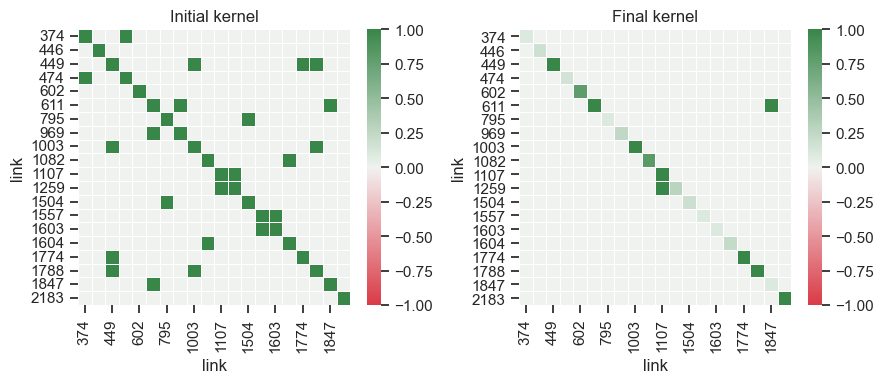

Final weights interaction:
 [[ 0.7929  0.      0.     ...  0.      0.      0.    ]
 [ 0.      0.1     0.     ...  0.      0.      0.    ]
 [ 0.     10.      6.391  ...  0.      0.      0.    ]
 ...
 [ 0.      0.      0.     ...  0.8562  0.      0.    ]
 [ 0.      0.      0.     ...  0.      1.1963  0.    ]
 [ 0.      0.      0.     ...  0.      0.      1.    ]]

Initial weights interaction:
 [[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


In [48]:
selected_links = np.random.choice(range(fresno_network.get_n_links()), 20, replace=False)

#weights_interaction = models['tvgodlulpe'].performance_function.weights[1].numpy()
weights_interaction = models['tvgodlulpe'].performance_function.model.layers[0].kernel_matrix.numpy()
initial_weights_interaction = models['tvgodlulpe'].performance_function.kernel_constraint.initial_values.numpy()
# Plot sign of values in flow interaction matrix
plot_flow_interaction_matrix(
    flow_interaction_matrix=weights_interaction,
    masking_matrix = initial_weights_interaction,
    # flow_interaction_matrix=np.where(weights_interaction>0, 1, -1)*np.where(weights_interaction==0, 0, 1),
    # masking_matrix = np.where(initial_weights_interaction>0, 1, -1)*np.where(initial_weights_interaction==0, 0, 1),
    links_ids = selected_links + 1,
    # vmin = -0.05, vmax = 0.05
    vmin = -1, vmax = 1
)

plt.savefig('output/figures/results/fresno-kernel-link-performance-functions-tvgodlulpe.png')

plt.show()

print(f'Final weights interaction:\n {weights_interaction}')
print(f'\nInitial weights interaction:\n',initial_weights_interaction)

# non_diagonal_mlp_weights = weights[~np.eye(weights.shape[0], dtype=bool)]
# print(f"Percentage of non-diagonal terms that are non-positive: {len(non_diagonal_mlp_weights[(non_diagonal_mlp_weights<=0)])/len(non_diagonal_mlp_weights):.2%}")

# non_zero_elements = weights_interaction[np.where(models['tvgodlulpe'].performance_function.kernel_constraint.initial_values.numpy()>0)]
# print(f"Percentage of non-zero terms that are positive: {len(non_zero_elements[(non_zero_elements>0)])/len(non_zero_elements):.2%}")

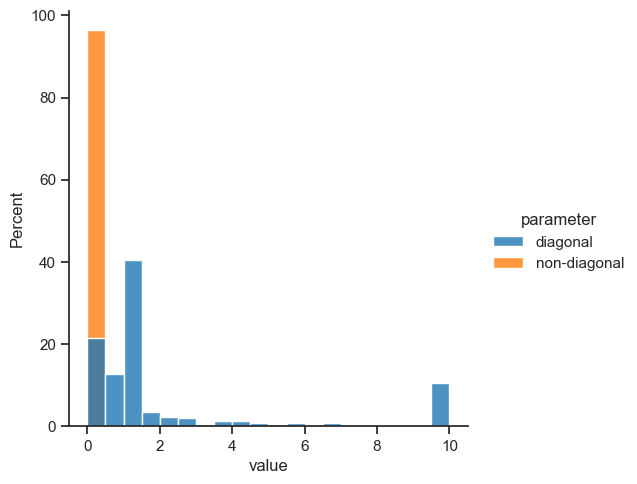

                 value  value_abs
parameter                        
diagonal      2.144919   2.144919
non-diagonal  0.133171   0.133171
              value
parameter          
diagonal       2413
non-diagonal  12314


In [49]:
# Distribution of weight in interaction flow matrix. Elements that are set to zero by default are excluded from non-diagonal
plot_data = pd.concat([pd.DataFrame({'value': tf.linalg.diag_part(weights_interaction).numpy().flatten(), 'parameter': 'diagonal'}),
                                  pd.DataFrame({'value': weights_interaction[np.where(~np.eye(weights_interaction.shape[0],dtype=bool)*models['tvgodlulpe'].performance_function.kernel_constraint.adjacency_constraint_matrix)], 'parameter': 'non-diagonal'})])

sns.displot(data = plot_data, x="value", kind="hist", stat='percent', common_norm=False, hue = "parameter", alpha=0.8,
            facet_kws=dict(sharey=False, sharex = False), binwidth = 0.5) # , col="parameter"

plt.savefig('output/figures/results/fresno-distribution-link-performance-parameters-tvgodlulpe.png')

plt.show()

plot_data['value_abs'] = plot_data.value.abs()

print(plot_data.groupby('parameter')[['value', 'value_abs']].mean())
print(plot_data.groupby('parameter')[['value']].count())

In [50]:
# Weight of polynomial
print(f"polynomial weights {tf.reduce_mean(models['tvgodlulpe'].performance_function.polynomial_layer.poly_weights,0).numpy()}")

polynomial weights [0.0646 0.1173 0.1486 0.1664]


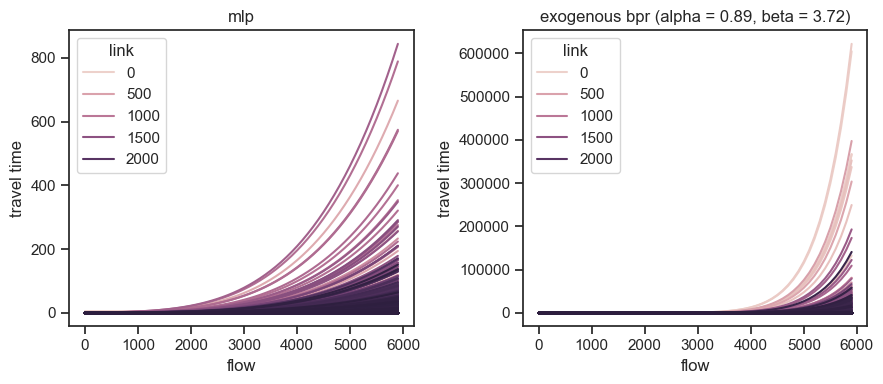

In [51]:
flow_range = range(0,6000,100)
sharey = False

plot_performance_functions(model = models['tvgodlulpe'],
                           network = fresno_network,
                           marginal = False,
                           # alpha=models['tvgodlulpe'].performance_function.polynomial_layer.alpha_prior,
                           # beta=models['tvgodlulpe'].performance_function.polynomial_layer.beta_prior,
                           alpha=models['tvodlulpe'].performance_function.alpha,
                           beta=models['tvodlulpe'].performance_function.beta,
                           sharey = sharey,
                           flow_range = flow_range
                           )

plt.savefig('output/figures/results/fresno-comparison-all-link-performance-functions-tvgodlulpe.png')

plt.show()

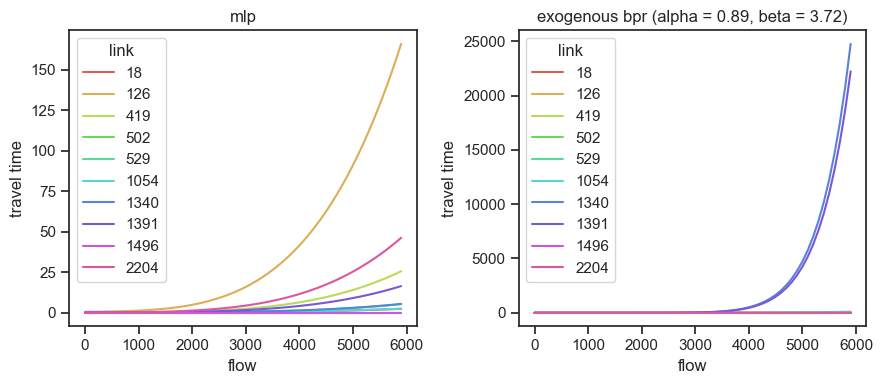

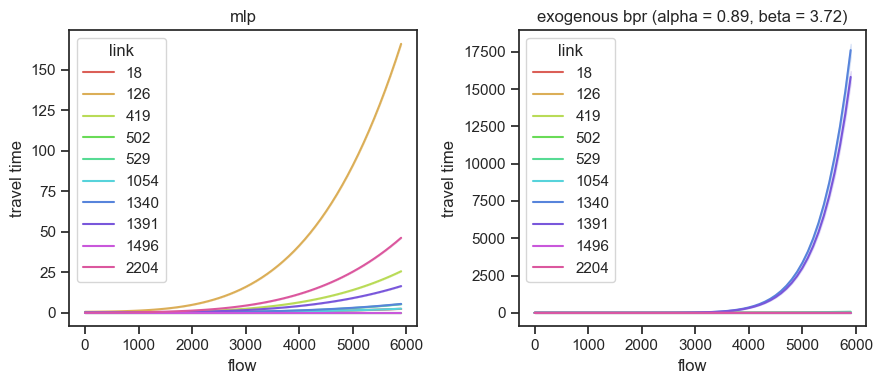

In [52]:
selected_links = np.random.choice(range(fresno_network.get_n_links()), 10, replace=False)

plot_performance_functions(model = models['tvgodlulpe'],
                           network = fresno_network,
                           marginal = False,
                           selected_links = selected_links,
                           # alpha=models['tvgodlulpe'].performance_function.polynomial_layer.alpha_prior,
                           # beta=models['tvgodlulpe'].performance_function.polynomial_layer.beta_prior,
                           alpha=models['tvodlulpe'].performance_function.alpha,
                           beta=models['tvodlulpe'].performance_function.beta,
                           palette = sns.color_palette("hls", len(selected_links)),
                           sharey = sharey,
                           flow_range = flow_range
                           )

plt.show()

# plot_performance_functions(model = models['tvgodlulpe'],
#                                network = fresno_network,
#                                marginal = False,
#                                selected_links = selected_links,
#                                alpha = 0.15,
#                                beta = 4,
#                                palette = sns.color_palette("hls", len(selected_links)),
#                                sharey = sharey,
#                                flow_range = flow_range
#                                )
# plt.show()

plot_performance_functions(model = models['tvgodlulpe'],
                           network = fresno_network,
                           marginal = True,
                           selected_links = selected_links,
                           # alpha = 0.15*np.ones(fresno_network.get_n_links()),
                           # beta = 4*np.ones(fresno_network.get_n_links()),
                           alpha=models['tvodlulpe'].performance_function.alpha,
                           beta=models['tvodlulpe'].performance_function.beta,
                           palette = sns.color_palette("hls", len(selected_links)),
                           sharey = sharey,
                           flow_range = flow_range
                           )
plt.show()

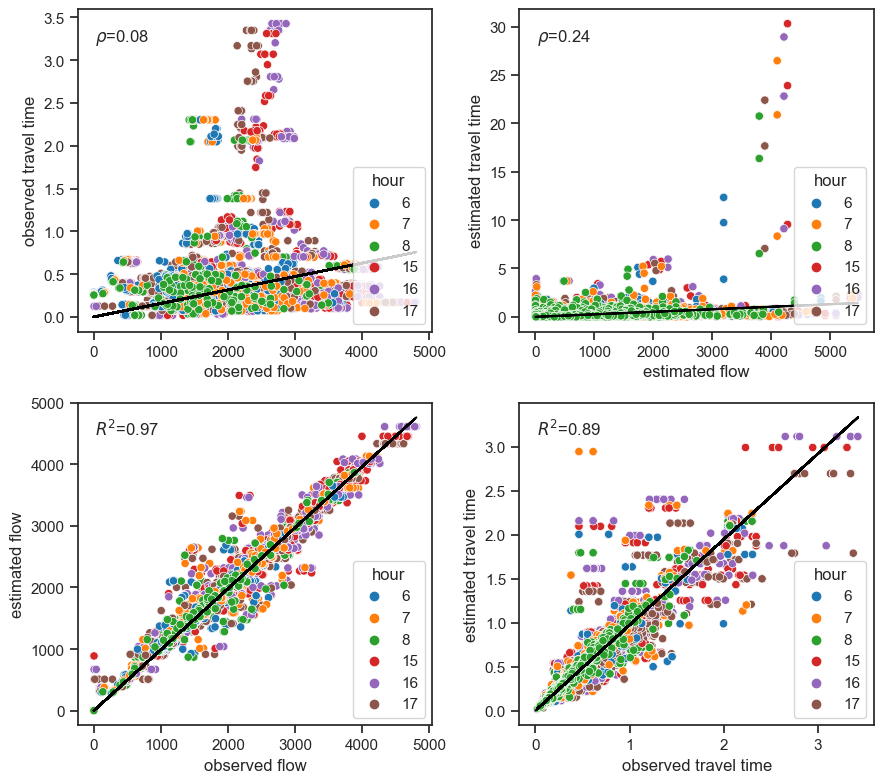

In [53]:
fig, axs = plot_flow_vs_traveltime(model = models['tvgodlulpe'],
                        observed_traveltime=models['tvgodlulpe'].mask_observed_traveltime(YT_train[:, :, 0]),
                        observed_flow= models['tvgodlulpe'].mask_observed_flow(YT_train[:,:,1]),
                        period_col = pd.DataFrame({'period': list(XT_train[:, :, -1].numpy().astype(int).flatten())})['period'].map(dict(zip(period_keys.period_id, period_keys.hour))).values.flatten(),
                        hour_label=True,
                        all_metrics = False
                        )

for ax in axs.reshape(-1):
    ax.legend(loc='lower right', title = 'hour')

plt.savefig('output/figures/results/fresno-scatter-flow-traveltime-tvgodlulpe.png')

plt.show()

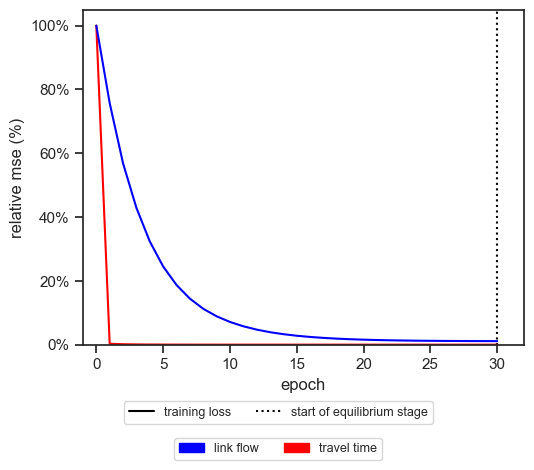

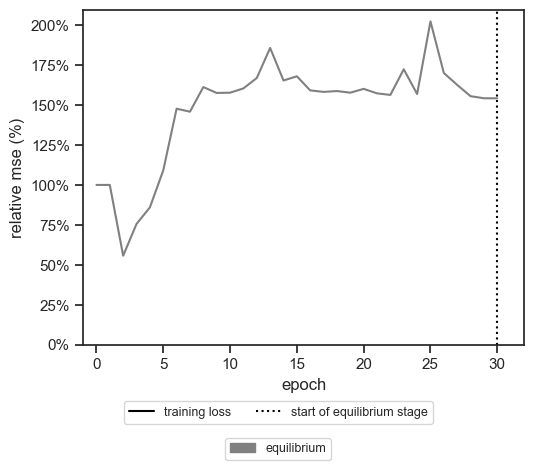

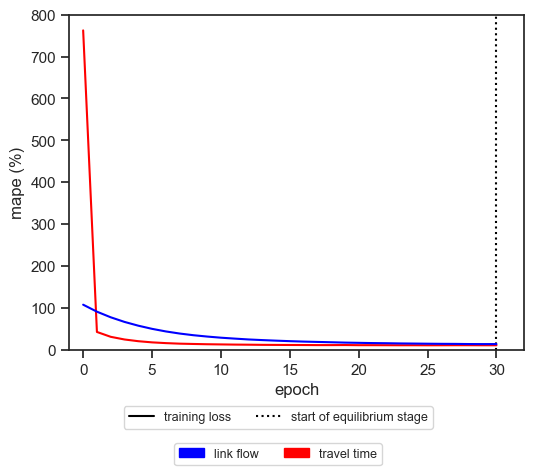

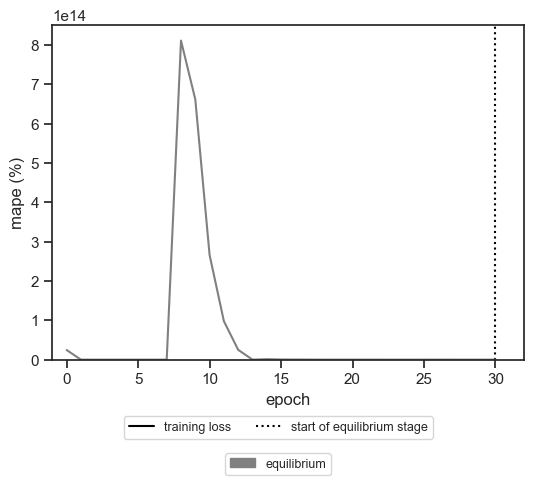

In [54]:
plot_predictive_performance(train_losses=train_results_dfs['tvgodlulpe'], val_losses=val_results_dfs['tvgodlulpe'],
                            xticks_spacing=_XTICKS_SPACING, show_validation=False,
                            # curves=['travel time', 'link flow'],
                            curves=['travel time', 'link flow'],
                            epochs_end_learning_stage = _EPOCHS['learning']
                            )

plt.savefig('output/figures/results/fresno-relative-mse-tvgodlulpe.png')

plot_predictive_performance(train_losses=train_results_dfs['tvgodlulpe'], val_losses=val_results_dfs['tvgodlulpe'],
                            xticks_spacing=_XTICKS_SPACING, show_validation=False,
                            curves=['equilibrium'],
                            epochs_end_learning_stage=_EPOCHS['learning'])

plot_predictive_performance(train_losses=train_results_dfs['tvgodlulpe'], val_losses=val_results_dfs['tvgodlulpe'],
                            xticks_spacing=_XTICKS_SPACING, show_validation=False,
                            curves=['travel time', 'link flow'],
                            epochs_end_learning_stage=_EPOCHS['learning'], prefix_metric='mape',
                            yaxis_label='mape (%)')

plt.savefig('output/figures/results/fresno-mape-tvgodlulpe.png')

plot_predictive_performance(train_losses=train_results_dfs['tvgodlulpe'], val_losses=val_results_dfs['tvgodlulpe'],
                            xticks_spacing=_XTICKS_SPACING, show_validation=False,
                            epochs_end_learning_stage=_EPOCHS['learning'], prefix_metric='mape',
                            curves=['equilibrium'],
                            yaxis_label='mape (%)')

plt.show()

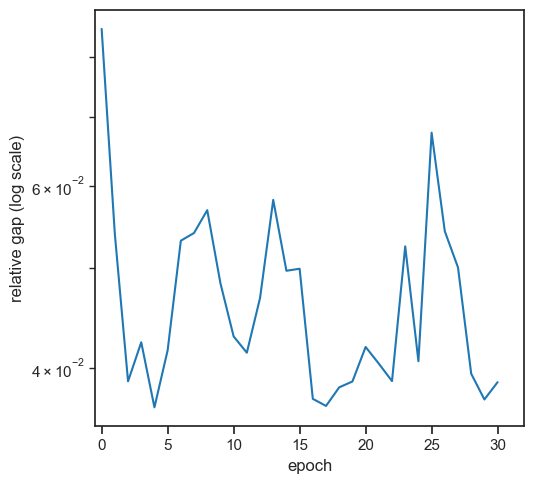

In [55]:
fig, ax = plot_convergence_estimates(
    estimates=train_results_dfs['tvgodlulpe'].assign(
        relative_gap=np.abs(train_results_dfs['tvgodlulpe']['relative_gap']))[['epoch', 'relative_gap']],
    xticks_spacing=_XTICKS_SPACING)

#ax.set_ylim(ymin=1e-2)
# ax.set_ylim(ymin=1e-2, ymax = 5.5e-2)
ax.set_xlim(xmin=-0.5)
ax.set_yscale('log')
ax.set_ylabel('relative gap (log scale)')
ax.get_legend().remove()

plt.savefig('output/figures/results/fresno-relative-gap-tvgodlulpe.png')

plt.show()

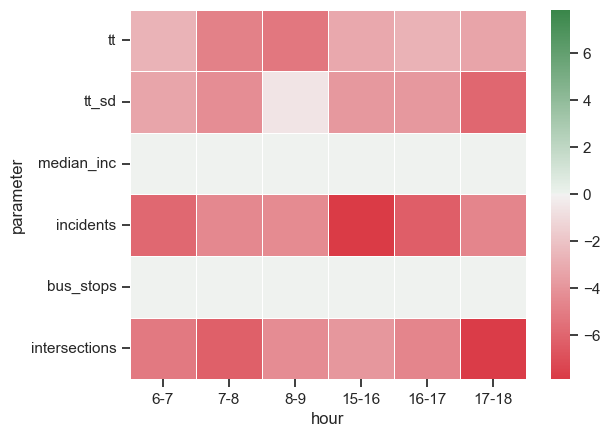

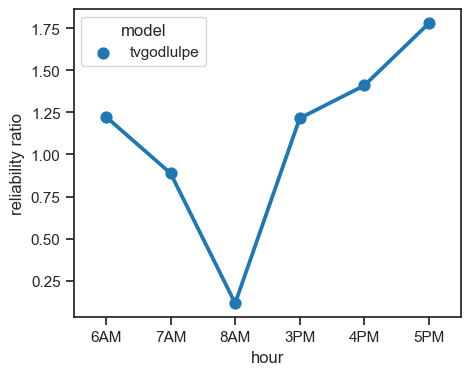

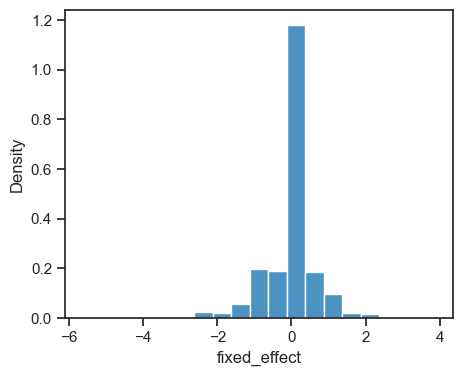

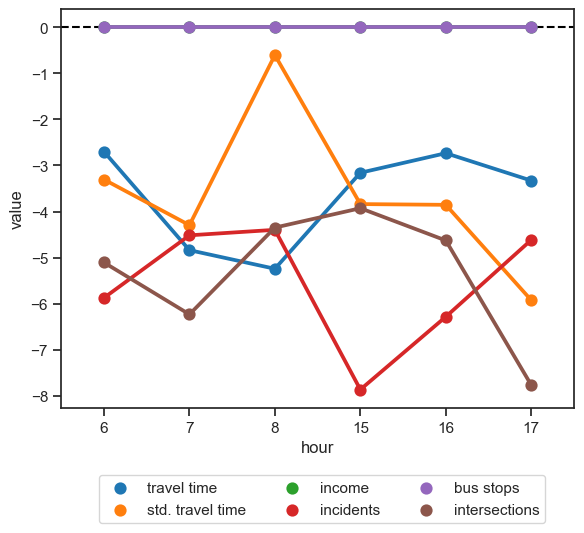

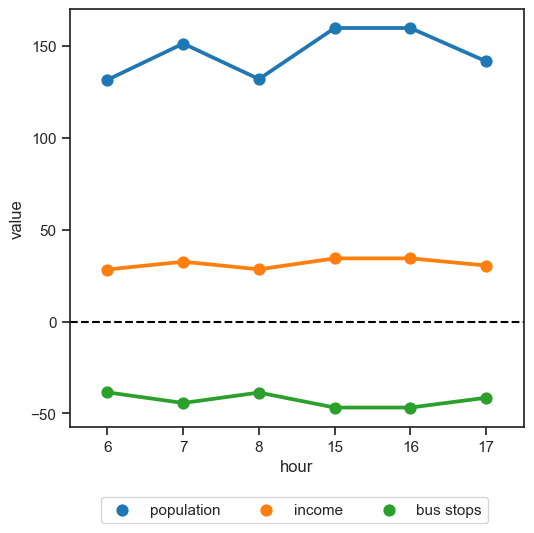

Theta: [[-2.6995 -4.837  -5.2409 -3.1575 -2.733  -3.3277]
 [-3.304  -4.2951 -0.605  -3.8373 -3.8535 -5.9233]
 [ 0.      0.      0.      0.      0.      0.    ]
 [-5.8718 -4.5149 -4.3958 -7.8621 -6.2816 -4.6149]
 [ 0.      0.      0.      0.      0.      0.    ]
 [-5.1047 -6.2304 -4.3475 -3.9269 -4.6268 -7.7641]]
Kappa: [[131.4958 151.2198 131.8887 159.6779 159.6841 141.5333]
 [ 28.293   32.5369  28.3776  34.3568  34.3581  30.4527]
 [-38.5438 -44.3253 -38.659  -46.8045 -46.8064 -41.486 ]]


In [56]:
# Compute utility parameters over time (heatmap) and value of travel time reliability (lineplot)
theta_df = plot_utility_parameters_periods(models['tvgodlulpe'], period_keys = period_keys, period_feature='hour')
#print(theta_df.values)

plot_rr_by_period(models['tvgodlulpe'], period_keys, model_key = 'tvgodlulpe', period_feature='hour')

fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (5,4))
sns.histplot(pd.DataFrame({'fixed_effect': np.array(models['tvodlulpe'].fixed_effect)}), stat='density', x="fixed_effect", alpha=0.8, ax = ax, binwidth=0.5)
plt.show()

# Plot parameters by period
theta_df = plot_utility_parameters_periods(models['tvgodlulpe'], period_keys=period_keys, period_feature='hour', plot = False).reset_index().\
    drop(['hour','index'], axis = 1).reset_index().rename(columns = {'index':'period'})

# theta_df = pd.melt(theta_df.assign(rr = theta_df.apply(compute_rr, axis=1)), id_vars = 'period', var_name = 'parameter').assign(group = 'utility')

theta_df = pd.melt(theta_df, id_vars = 'period', var_name = 'parameter').assign(group = 'utility')

kappa_df = pd.concat([pd.DataFrame({'period': [period], 'parameter': [feature], 'value': [models['tvgodlulpe'].kappa[period, i].numpy()]}) for period in range(models['tvgodlulpe'].kappa.shape[0]) for i, feature in enumerate(models['tvgodlulpe'].generation.features)]).assign(group = 'generation')

parameters_df = pd.concat([theta_df, kappa_df]).\
    replace({'tt': 'travel time', 'tt_sd': 'std. travel time', 's': 'intersections', 'bus_stops': 'bus stops', 'median_inc': 'income', 'rr': 'reliability ratio'})

parameters_df['hour'] = parameters_df['period'].map({v:period_keys[period_keys.period_id == k]['hour'].iloc[0] for k,v in models['tvgodlulpe'].period_dict.items()})

fig, ax = plot_parameters(df = parameters_df[parameters_df.group == 'utility'], n_cols_legend = 3, figsize = (6,5.5), hour_label = True)

plt.axhline(0, linestyle ='dashed', color = 'black')

plt.savefig('output/figures/results/fresno-utility-periods-tvgodlulpe.png')

plot_parameters(df = parameters_df[parameters_df.group == 'generation'], n_cols_legend = 3, figsize = (5.5,5.5), hour_label = True)

plt.axhline(0, linestyle ='dashed', color = 'black')

plt.savefig('output/figures/results/fresno-generation-periods-tvgodlulpe.png')

plt.show()

print('Theta:', models['tvgodlulpe'].theta.numpy().T)
print('Kappa:', models['tvgodlulpe'].kappa.numpy().T)

(           historic_od         6AM         7AM         8AM         3PM   
 1618 175     1840.4001    0.011605    0.006231    0.015008    0.007819  \
      694     1182.4533    0.013101    0.007084    0.014618    0.009037   
 42   1617    1139.6952    3.455555   76.253395    4.885706  239.619186   
 693  1617    1077.8859  103.329308  105.112411  338.688232   34.497246   
 272  1614     598.5315    0.048564    0.023415    0.059909    0.065092   
 701  1629     577.9746    0.784135    2.225801   22.556353    1.729878   
 226  1651     472.3362    2.549335    0.177862    0.603477   12.601439   
 220  1688     446.1534    3.465651    0.989140   14.328269    5.400887   
 104  1693     430.1766    0.711407    2.027905    3.237144    4.168818   
 871  1679     428.9796    0.726992    1.577500    2.522360    1.130578   
 1615 88       426.7179  598.598450  686.728027  593.564209  739.425415   
 807  1650     418.2822   14.538198    0.590850    4.691440    6.626658   
 752  1633     392.5845  

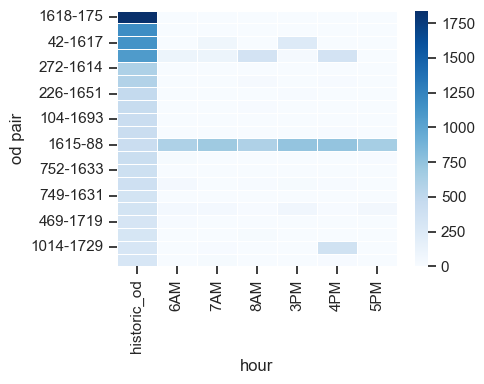

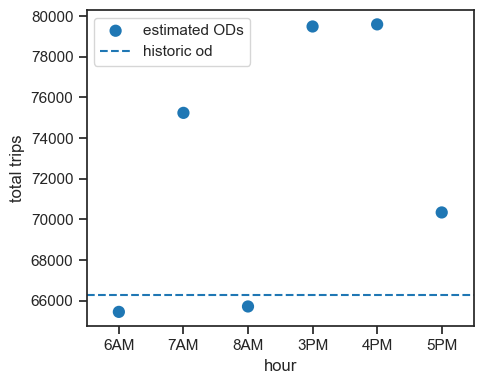

In [57]:
# Plot heatmap with flows of top od pairs
plot_top_od_flows_periods(models['tvgodlulpe'],
                          historic_od= fresno_network.q.flatten(),
                          period_keys = period_keys,
                          period_feature='hour', top_k=20)

In [58]:
print(f"theta = "
      f"{dict(zip(models['tvgodlulpe'].utility.true_values.keys(), list(np.mean(models['tvgodlulpe'].theta.numpy(), axis=0))))}")
print(f"kappa= "
      f"{dict(zip(models['tvgodlulpe'].generation.features, list(np.mean(models['tvgodlulpe'].kappa.numpy(), axis=0))))}")

if models['tvgodlulpe'].performance_function.type == 'bpr':
    print(f"alpha = {np.mean(models['tvgodlulpe'].performance_function.alpha): 0.2f}, "
          f"beta  = {np.mean(models['tvgodlulpe'].performance_function.beta): 0.2f}")

print(f"Avg abs diff of observed and estimated OD: "
      f"{np.mean(np.abs(models['tvgodlulpe'].q - fresno_network.q.flatten())): 0.2f}")

print(f"Avg observed OD: {np.mean(np.abs(fresno_network.q.flatten())): 0.2f}")

theta = {'tt': -3.6659327, 'tt_sd': -3.6363544, 'median_inc': 0.0, 'incidents': -5.590194, 'bus_stops': 0.0, 'intersections': -5.3333993}
kappa= {'population': 145.91658, 'income': 31.395859, 'bus_stops': -42.770832}
Avg abs diff of observed and estimated OD:  16.33
Avg observed OD:  9.51


In [59]:
metrics_df = models['tvgodlulpe'].compute_loss_metrics(metrics={'mape': mape, 'mse': mse, 'r2': r2_score},
                                                      X=XT_train, Y=YT_train).assign(dataset='training')
# metrics_df = pd.concat([metrics_df,
#                         models['tvgodlulpe'].compute_loss_metrics(metrics={'mape': mape, 'mse': mse, 'r2': r2_score},
#                                                                  X=XT_val, Y=YT_val).assign(dataset='validation'),
#                         compute_benchmark_metrics(metrics={'mape': mape, 'mse': mse, 'r2': r2_score}, Y_ref=YT_train,
#                                                   Y=YT_val).assign(
#                             dataset='benchmark')
#                         ])

with pd.option_context('display.float_format', '{:0.3g}'.format):
    print(pd.pivot(metrics_df, index=['component', 'dataset'], columns=['metric'])['value'])
print(f'runtime: {time.time()-t0:0.1f} [s]')

metric                   mape      mse    r2
component   dataset                         
equilibrium training 3.06e+04 2.72e+04 0.953
flow        training     13.3 4.91e+04 0.919
traveltime  training     10.9  0.00683 0.896
runtime: 5177.5 [s]


# Forecasting

In [60]:
generation_factors = compute_generation_factors(period_column=XT_train[:, :, -1, None].numpy(),
                                                flow_column=YT_train[:,:,1, None].numpy(), reference_period=10)

print(generation_factors)

n_periods = len(np.unique(XT_train[:, :, -1].numpy().flatten()))

growth_factor = 7.9/6.6

generated_trips = growth_factor*generation_factors.values[:,np.newaxis]*compute_generated_trips(q = fresno_network.q.flatten()[np.newaxis,:], ods= fresno_network.ods)

period_id
0.0    0.823474
1.0    0.946993
2.0    0.825935
3.0    0.999961
4.0    1.000000
5.0    0.886333
Name: flow, dtype: float32


## TVODLULPE

In [118]:
# models['reference-model'], _ = create_tvgodlulpe_model_fresno(
#     n_periods=n_periods, network=fresno_network, historic_g=generation_factors.values[:, np.newaxis] * generated_trips)
#
# train_results_dfs['reference-model'], val_results_dfs['reference-model'] = models['reference-model'].fit(
#     XT_train, YT_train, XT_val, YT_val,
#     node_data=node_data,
#     optimizers= {'learning': tf.keras.optimizers.legacy.Adam(learning_rate=_LR['learning']),
#                  'equilibrium': tf.keras.optimizers.legacy.Adam(learning_rate=_LR['equilibrium'])
#                  },
#     batch_size=_BATCH_SIZE,
#     # loss_weights= _LOSS_WEIGHTS,
#     loss_weights = {'od': 0, 'traveltime': 1, 'flow': 1, 'equilibrium': 1},
#     loss_metric=_LOSS_METRIC,
#     equilibrium_stage= True,
#     alternating_optimization= False,
#     pretrain_link_flows = True,
#     threshold_relative_gap= 2e-1,
#     epochs_print_interval=_EPOCHS_PRINT_INTERVAL,
#     epochs=_EPOCHS)

reference_model = models['tvodlulpe']

In [119]:
# Create model for inference (make sure that the arguments are the same than those used to create the reference model)
inference_model, _ = create_tvgodlulpe_model_fresno(
    n_periods= n_periods, network = fresno_network,
    performance_function = create_bpr(network = fresno_network, dtype = _DTYPE, alpha_prior = 0.9327, beta_prior = 4.1017),
    od_parameters = ODParameters(key='od',
                                 #initial_values= generation_factors.values[:,np.newaxis]*tntp_network.q.flatten(),
                                 initial_values = tf.stack(q_historic),
                                 historic_values={10: q_historic[0].flatten()},
                                 ods=fresno_network.ods,
                                 n_periods=n_periods,
                                 time_varying=True,
                                 trainable=True),
    generation = False,
    utility_trainable = True
)

inference_model.build()
#inference_model.update_predictions(XT_train, update_period_dict = True)

In [120]:
# inference_model.load_weights("output/models/230616010949_tvgodlulpe_fresno.h5")
inference_model.load_weights(reference_model._filepath_weights)

### - Model estimated with all data from 2019

In [121]:
# reference_model.load_node_data(node_data)
# This should convergence immediately when the data for prediction is equal to training set
_ = inference_model.predict(XT_train,
                        # period_dict = reference_model.period_dict,
                        node_data=node_data,
                        loss_metric=_LOSS_METRIC,
                        pretrain_link_flows = False,
                        batch_size= 1,
                        # optimizer= tf.keras.optimizers.legacy.Adam(learning_rate=_LR['equilibrium']),
                        # batch_size= None,
                        optimizer= tf.keras.optimizers.legacy.Adam(learning_rate=1e-1),
                        loss_weights={'equilibrium': 1},
                        # threshold_relative_gap=5e-2,  # _RELATIVE_GAP,
                        threshold_relative_gap=_RELATIVE_GAP,
                        epochs_print_interval=_EPOCHS_PRINT_INTERVAL,
                        epochs=100)


Computing gradient based equilibrium

Model training

hyperparameters loss function: {'equilibrium': 1}

number of periods: 6, batch size: 1, threshold relative gap: 0.05
training set -> timepoints: 90, obs [t x]: nan, coverage [t x]: nan

0/100: train mse=1.6e+04, theta = [-2.773 -2.986  0.    -4.76  -0.085 -4.531], avg rr = 1.08, avg theta fixed effect = -0.049, loss prop od=1.3e+03, total trips=[5.93e+04 5.96e+04 5.59e+04 7.99e+04 8.11e+04 8.53e+04], avg alpha=0.89, avg beta=3.7, lambda eq=1, relative gap=0.034, train equilibrium loss=1.6e+04, time: 1.2

Relative gap threshold of 0.05 was achieved in equilibrium stage


In [122]:
with pd.option_context('display.float_format', '{:0.3g}'.format):
    print('\n')
    training_metrics = inference_model.compute_loss_metrics(metrics={'mape': mape, 'mse': mse, 'r2': r2_score},
                                                            X=XT_train, Y=YT_train)
    print(training_metrics)

# model.summary()



     component    value metric
0         flow     12.6   mape
1   traveltime     6.37   mape
2  equilibrium     61.2   mape
0         flow 4.61e+04    mse
1   traveltime  0.00192    mse
2  equilibrium 1.52e+04    mse
0         flow    0.924     r2
1   traveltime    0.971     r2
2  equilibrium    0.978     r2


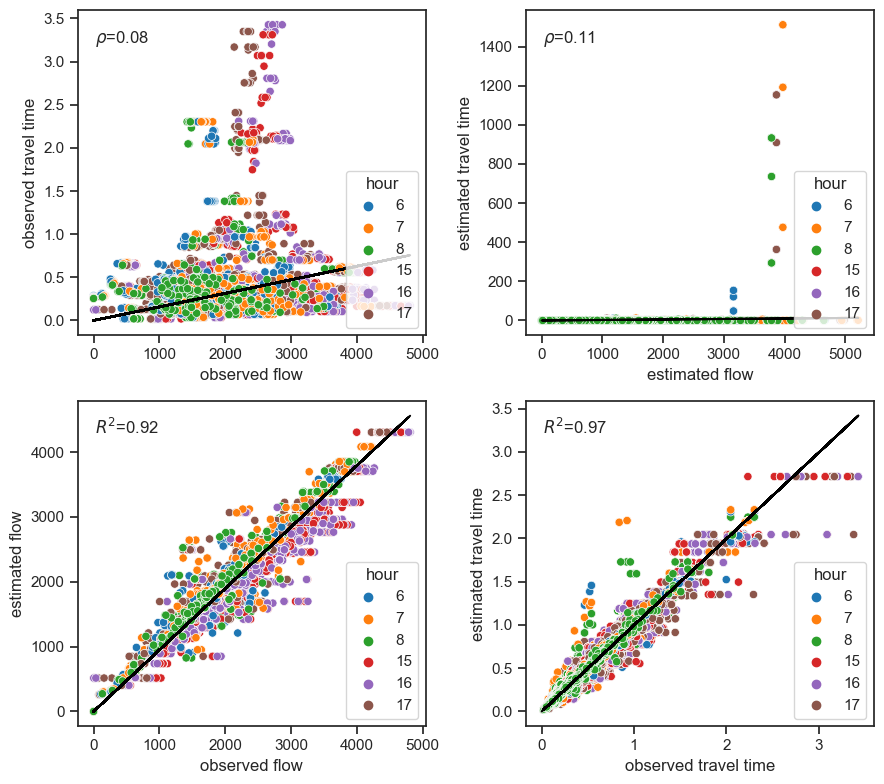

In [123]:
fig, axs = plot_flow_vs_traveltime(model = inference_model,
                        observed_traveltime=inference_model.mask_observed_traveltime(YT_train[:, :, 0]),
                        observed_flow= inference_model.mask_observed_flow(YT_train[:,:,1]),
                        period_col = pd.DataFrame({'period': list(XT_train[:, :, -1].numpy().astype(int).flatten())})['period'].map(dict(zip(period_keys.period_id, period_keys.hour))).values.flatten(),
                        hour_label=True,
                        all_metrics = False
                        )

for ax in axs.reshape(-1):
    ax.legend(loc='lower right', title = 'hour')

plt.show()

### -Make prediction on 2020, the validation set, without computing equilibrium

In [124]:

_ = inference_model.predict(XT_val,
                            node_data=node_data,
                            loss_metric=_LOSS_METRIC,
                            batch_size= 1,
                            optimizer= tf.keras.optimizers.legacy.Adam(learning_rate=_LR['equilibrium']),
                            pretrain_link_flows = False,
                            # batch_size= None,
                            # optimizer= tf.keras.optimizers.legacy.Adam(learning_rate=1e-1),
                            loss_weights={'equilibrium': 1},
                            threshold_relative_gap=float('inf'),  # _RELATIVE_GAP,
                            epochs_print_interval=_EPOCHS_PRINT_INTERVAL,
                            epochs=100)


Computing gradient based equilibrium

Model training

hyperparameters loss function: {'equilibrium': 1}

number of periods: 6, batch size: 1, threshold relative gap: inf
training set -> timepoints: 78, obs [t x]: nan, coverage [t x]: nan

0/100: train mse=4.6e+04, theta = [-2.773 -2.986  0.    -4.76  -0.085 -4.531], avg rr = 1.08, avg theta fixed effect = -0.049, loss prop od=nan, total trips=[5.93e+04 5.96e+04 5.59e+04 7.99e+04 8.11e+04 8.53e+04], avg alpha=0.89, avg beta=3.7, lambda eq=1, relative gap=0.09, train equilibrium loss=4.6e+04, time: 1.2

Relative gap threshold of inf was achieved in equilibrium stage


In [125]:
with pd.option_context('display.float_format', '{:0.3g}'.format):
    print('\n')
    validation_metrics = inference_model.compute_loss_metrics(metrics = {'mape': mape, 'mse': mse, 'r2': r2_score}, X = XT_val, Y = YT_val)
    print(validation_metrics)



     component    value metric
0         flow     19.4   mape
1   traveltime     10.7   mape
2  equilibrium 2.46e+13   mape
0         flow 1.56e+05    mse
1   traveltime  0.00563    mse
2  equilibrium 4.47e+04    mse
0         flow    0.736     r2
1   traveltime    0.908     r2
2  equilibrium    0.935     r2


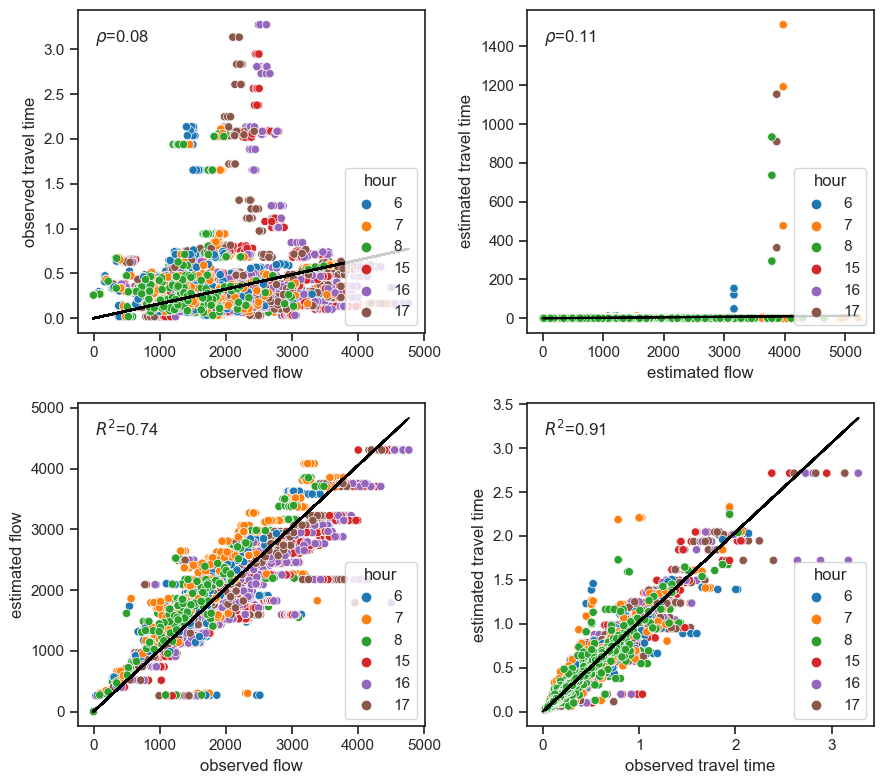

In [126]:
fig, axs = plot_flow_vs_traveltime(model = inference_model,
                        observed_traveltime=inference_model.mask_observed_traveltime(YT_val[:, :, 0]),
                        observed_flow= inference_model.mask_observed_flow(YT_val[:,:,1]),
                        # scatter_kws={"color": sns.color_palette("deep")[0], 's':4, 'alpha': 1}, line_kws={"color": "black"},
                        period_col = pd.DataFrame({'period': list(XT_val[:, :, -1].numpy().astype(int).flatten())})['period'].map(dict(zip(period_keys.period_id, period_keys.hour))).values.flatten(),
                        hour_label=True,
                        all_metrics = False
                        )

for ax in axs.reshape(-1):
    ax.legend(loc='lower right', title = 'hour')

plt.savefig('output/figures/results/fresno-scatter-flow-traveltime-outofsample-tvodlulpe-without-equilibrium.png')

plt.show()

### - Make prediction on 2020, the validation set, computing equilibrium

In [127]:

_ = inference_model.predict(XT_val,
                            node_data=node_data,
                            loss_metric=_LOSS_METRIC,
                            batch_size= 1,
                            optimizer= tf.keras.optimizers.legacy.Adam(learning_rate=_LR['equilibrium']),
                            pretrain_link_flows = False,
                            # batch_size= None,
                            # optimizer= tf.keras.optimizers.legacy.Adam(learning_rate=1e-1),
                            loss_weights={'equilibrium': 1},
                            threshold_relative_gap=5e-2,  # _RELATIVE_GAP,
                            epochs_print_interval=_EPOCHS_PRINT_INTERVAL,
                            epochs=100)


Computing gradient based equilibrium

Model training

hyperparameters loss function: {'equilibrium': 1}

number of periods: 6, batch size: 1, threshold relative gap: 0.05
training set -> timepoints: 78, obs [t x]: nan, coverage [t x]: nan

0/100: train mse=4.6e+04, theta = [-2.773 -2.986  0.    -4.76  -0.085 -4.531], avg rr = 1.08, avg theta fixed effect = -0.049, loss prop od=nan, total trips=[5.93e+04 5.96e+04 5.59e+04 7.99e+04 8.11e+04 8.53e+04], avg alpha=0.89, avg beta=3.7, lambda eq=1, relative gap=0.09, train equilibrium loss=4.6e+04, time: 1.1

1/100: train mse=4.3e+04, theta = [-2.773 -2.986  0.    -4.76  -0.085 -4.531], avg rr = 1.08, avg theta fixed effect = -0.049, loss prop od=nan, total trips=[5.93e+04 5.96e+04 5.59e+04 7.99e+04 8.11e+04 8.53e+04], avg alpha=0.89, avg beta=3.7, lambda eq=1, relative gap=0.078, train equilibrium loss=4.3e+04, time: 99.0

2/100: train mse=4e+04, theta = [-2.773 -2.986  0.    -4.76  -0.085 -4.531], avg rr = 1.08, avg theta fixed effect = -0

In [128]:
# with pd.option_context('display.float_format', '{:0.3g}'.format):
#     metrics_df = pd.concat([training_metrics.assign(dataset = 'training'),
#                             validation_metrics.assign(dataset = 'validation')])
#     print(pd.pivot(metrics_df, index=['component', 'dataset'], columns=['metric'])['value'])

with pd.option_context('display.float_format', '{:0.3g}'.format):
    print('\n')
    validation_metrics = inference_model.compute_loss_metrics(metrics = {'mape': mape, 'mse': mse, 'r2': r2_score}, X = XT_val, Y = YT_val)
    print(validation_metrics)



     component    value metric
0         flow       21   mape
1   traveltime     11.9   mape
2  equilibrium       11   mape
0         flow 1.68e+05    mse
1   traveltime  0.00739    mse
2  equilibrium 2.62e+04    mse
0         flow    0.715     r2
1   traveltime    0.879     r2
2  equilibrium    0.963     r2


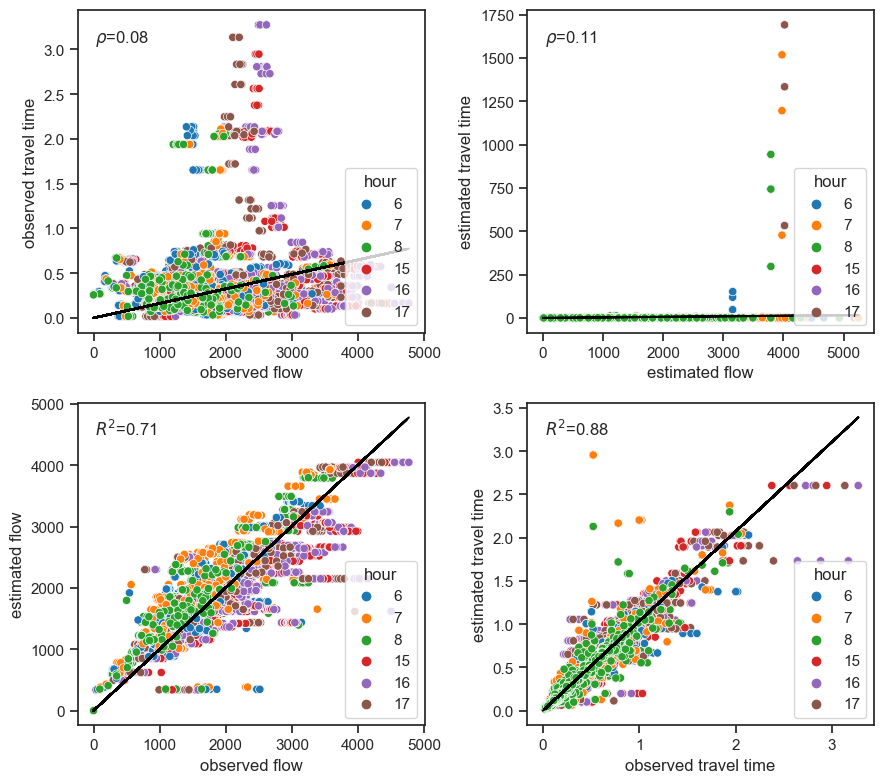

In [129]:
fig, axs = plot_flow_vs_traveltime(model = inference_model,
                        observed_traveltime=inference_model.mask_observed_traveltime(YT_val[:, :, 0]),
                        observed_flow= inference_model.mask_observed_flow(YT_val[:,:,1]),
                        period_col = pd.DataFrame({'period': list(XT_val[:, :, -1].numpy().astype(int).flatten())})['period'].map(dict(zip(period_keys.period_id, period_keys.hour))).values.flatten(),
                        hour_label=True,
                        all_metrics = False
                        )

for ax in axs.reshape(-1):
    ax.legend(loc='lower right', title = 'hour')

plt.savefig('output/figures/results/fresno-scatter-flow-traveltime-outofsample-tvodlulpe-with-equilibrium.png')

plt.show()

## TVGODLULPE

In [61]:
# models['reference-model'], _ = create_tvgodlulpe_model_fresno(
#     n_periods=n_periods, network=fresno_network, historic_g=generation_factors.values[:, np.newaxis] * generated_trips)
#
# train_results_dfs['reference-model'], val_results_dfs['reference-model'] = models['reference-model'].fit(
#     XT_train, YT_train, XT_val, YT_val,
#     node_data=node_data,
#     optimizers= {'learning': tf.keras.optimizers.legacy.Adam(learning_rate=_LR['learning']),
#                  'equilibrium': tf.keras.optimizers.legacy.Adam(learning_rate=_LR['equilibrium'])
#                  },
#     batch_size=_BATCH_SIZE,
#     # loss_weights= _LOSS_WEIGHTS,
#     loss_weights = {'od': 0, 'traveltime': 1, 'flow': 1, 'equilibrium': 1},
#     loss_metric=_LOSS_METRIC,
#     equilibrium_stage= True,
#     alternating_optimization= False,
#     pretrain_link_flows = True,
#     threshold_relative_gap= 2e-1,
#     epochs_print_interval=_EPOCHS_PRINT_INTERVAL,
#     epochs=_EPOCHS)

reference_model = models['tvgodlulpe']

In [62]:
# Create model for inference (make sure that the arguments are the same than those used to create the reference model)
inference_model, _ = create_tvgodlulpe_model_fresno(
    n_periods = n_periods,
    network = fresno_network,
    performance_function = create_mlp(network = fresno_network,
                                      poly_order = 4, alpha_prior = 1, beta_prior = 4, pretrain = False, link_specific = False),
    historic_g= generated_trips,
    generation = True,
    utility_trainable = True)

inference_model.build()
#inference_model.update_predictions(XT_train, update_period_dict = True)

In [63]:
# inference_model.load_weights("output/models/230616010949_tvgodlulpe_fresno.h5")
inference_model.load_weights(reference_model._filepath_weights)

### - Model estimated with all data from 2019

In [117]:
# reference_model.load_node_data(node_data)
# This should convergence immediately when the data for prediction is equal to training set
_ = inference_model.predict(XT_train,
                        # period_dict = reference_model.period_dict,
                        node_data=node_data,
                        loss_metric=_LOSS_METRIC,
                        pretrain_link_flows = False,
                        batch_size= 1,
                        # optimizer= tf.keras.optimizers.legacy.Adam(learning_rate=_LR['equilibrium']),
                        # batch_size= None,
                        optimizer= tf.keras.optimizers.legacy.Adam(learning_rate=1e-1),
                        loss_weights={'equilibrium': 1},
                        # threshold_relative_gap=5e-2,  # _RELATIVE_GAP,
                        threshold_relative_gap=_RELATIVE_GAP,
                        epochs_print_interval=_EPOCHS_PRINT_INTERVAL,
                        epochs=100)


Computing gradient based equilibrium

Model training

hyperparameters loss function: {'equilibrium': 1}

number of periods: 6, batch size: 1, threshold relative gap: 0.05
training set -> timepoints: 90, obs [t x]: nan, coverage [t x]: nan

0/100: train mse=2.7e+04, theta = [-3.666 -3.636  0.    -5.59   0.    -5.333], avg rr = 0.99, avg theta fixed effect = -0.067, loss prop od=nan, total trips=[6.54e+04 7.52e+04 6.57e+04 7.95e+04 7.96e+04 7.03e+04], polynomial weights: [6.5e-02 1.2e-01 1.5e-01 1.7e-01], kappa = [145.917  31.396 -42.771], lambda eq=1, relative gap=0.039, train equilibrium loss=2.7e+04, time: 1.4

Relative gap threshold of 0.05 was achieved in equilibrium stage


In [65]:
with pd.option_context('display.float_format', '{:0.3g}'.format):
    print('\n')
    training_metrics = inference_model.compute_loss_metrics(metrics={'mape': mape, 'mse': mse, 'r2': r2_score},
                                                            X=XT_train, Y=YT_train)
    print(training_metrics)

# model.summary()



     component    value metric
0         flow     13.3   mape
1   traveltime     10.9   mape
2  equilibrium 3.06e+04   mape
0         flow 4.91e+04    mse
1   traveltime  0.00683    mse
2  equilibrium 2.72e+04    mse
0         flow    0.919     r2
1   traveltime    0.896     r2
2  equilibrium    0.953     r2


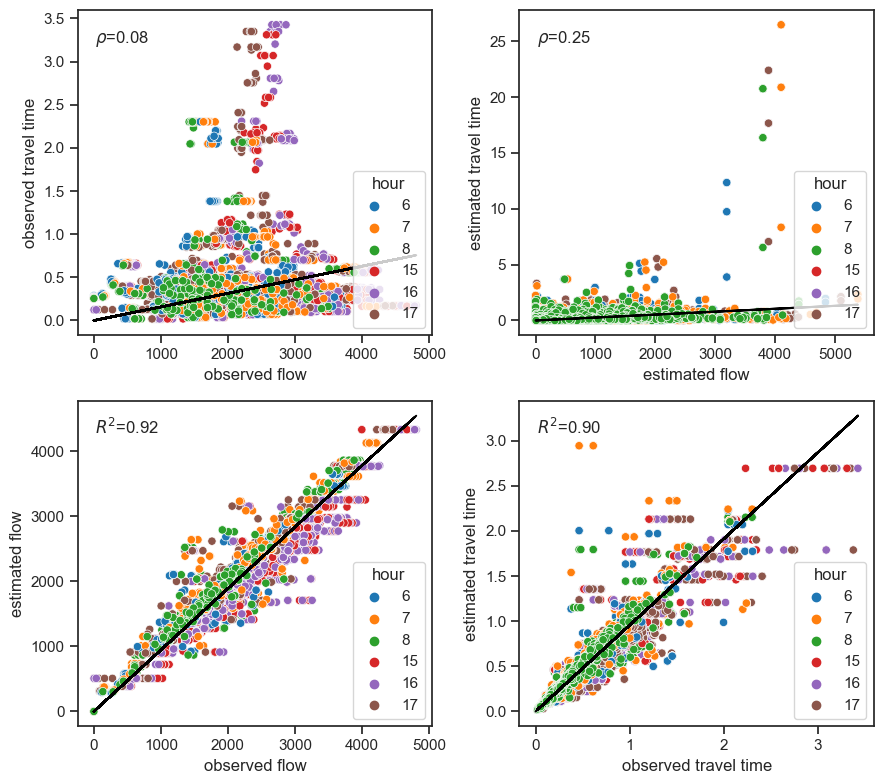

In [66]:
fig, axs = plot_flow_vs_traveltime(model = inference_model,
                        observed_traveltime=inference_model.mask_observed_traveltime(YT_train[:, :, 0]),
                        observed_flow= inference_model.mask_observed_flow(YT_train[:,:,1]),
                        period_col = pd.DataFrame({'period': list(XT_train[:, :, -1].numpy().astype(int).flatten())})['period'].map(dict(zip(period_keys.period_id, period_keys.hour))).values.flatten(),
                        hour_label=True,
                        all_metrics = False
                        )

for ax in axs.reshape(-1):
    ax.legend(loc='lower right', title = 'hour')

plt.show()

### -Make prediction on 2020, the validation set, without computing equilibrium

In [67]:

_ = inference_model.predict(XT_val,
                            node_data=node_data,
                            loss_metric=_LOSS_METRIC,
                            batch_size= 1,
                            optimizer= tf.keras.optimizers.legacy.Adam(learning_rate=_LR['equilibrium']),
                            pretrain_link_flows = False,
                            # batch_size= None,
                            # optimizer= tf.keras.optimizers.legacy.Adam(learning_rate=1e-1),
                            loss_weights={'equilibrium': 1},
                            threshold_relative_gap=float('inf'),  # _RELATIVE_GAP,
                            epochs_print_interval=_EPOCHS_PRINT_INTERVAL,
                            epochs=100)


Computing gradient based equilibrium

Model training

hyperparameters loss function: {'equilibrium': 1}

number of periods: 6, batch size: 1, threshold relative gap: inf
training set -> timepoints: 78, obs [t x]: nan, coverage [t x]: nan

0/100: train mse=3.7e+04, theta = [-3.666 -3.636  0.    -5.59   0.    -5.333], avg rr = 0.99, avg theta fixed effect = -0.067, loss prop od=nan, total trips=[6.54e+04 7.52e+04 6.57e+04 7.95e+04 7.96e+04 7.03e+04], polynomial weights: [6.5e-02 1.2e-01 1.5e-01 1.7e-01], kappa = [145.917  31.396 -42.771], lambda eq=1, relative gap=0.064, train equilibrium loss=3.7e+04, time: 1.3

Relative gap threshold of inf was achieved in equilibrium stage


In [68]:
with pd.option_context('display.float_format', '{:0.3g}'.format):
    print('\n')
    validation_metrics = inference_model.compute_loss_metrics(metrics = {'mape': mape, 'mse': mse, 'r2': r2_score}, X = XT_val, Y = YT_val)
    print(validation_metrics)



     component    value metric
0         flow     19.5   mape
1   traveltime     12.2   mape
2  equilibrium 2.24e+14   mape
0         flow 1.58e+05    mse
1   traveltime  0.00722    mse
2  equilibrium 3.54e+04    mse
0         flow    0.733     r2
1   traveltime    0.882     r2
2  equilibrium    0.938     r2


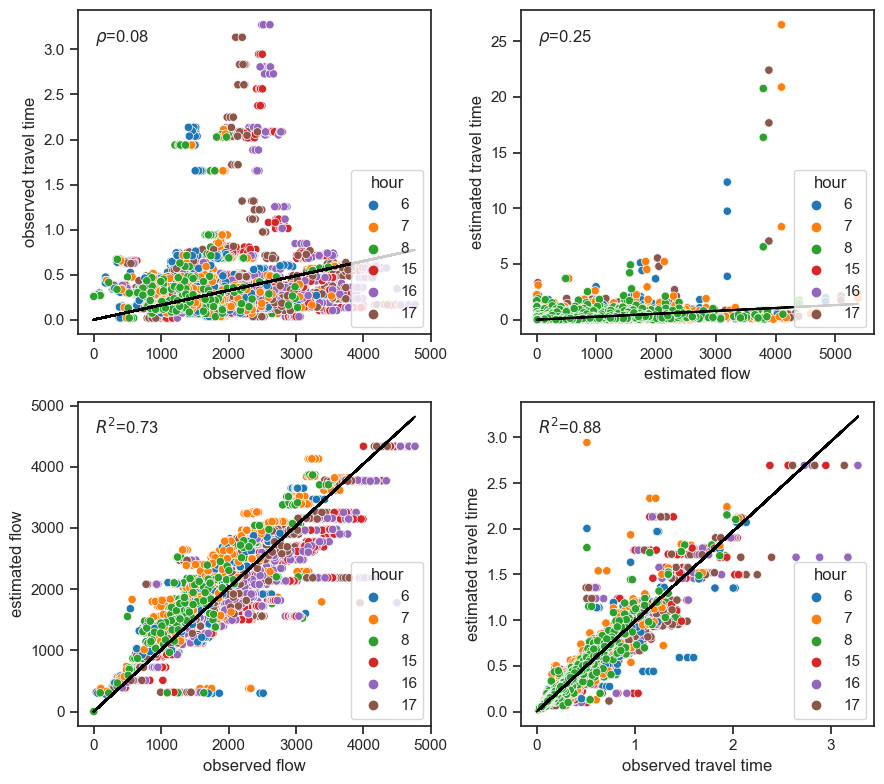

In [69]:
fig, axs = plot_flow_vs_traveltime(model = inference_model,
                        observed_traveltime=inference_model.mask_observed_traveltime(YT_val[:, :, 0]),
                        observed_flow= inference_model.mask_observed_flow(YT_val[:,:,1]),
                        # scatter_kws={"color": sns.color_palette("deep")[0], 's':4, 'alpha': 1}, line_kws={"color": "black"},
                        period_col = pd.DataFrame({'period': list(XT_val[:, :, -1].numpy().astype(int).flatten())})['period'].map(dict(zip(period_keys.period_id, period_keys.hour))).values.flatten(),
                        hour_label=True,
                        all_metrics = False
                        )

for ax in axs.reshape(-1):
    ax.legend(loc='lower right', title = 'hour')

plt.savefig('output/figures/results/fresno-scatter-flow-traveltime-outofsample-tvgodlulpe-without-equilibrium.png')

plt.show()

### - Make prediction on 2020, the validation set, computing equilibrium

In [70]:

_ = inference_model.predict(XT_val,
                            node_data=node_data,
                            loss_metric=_LOSS_METRIC,
                            batch_size= 1,
                            optimizer= tf.keras.optimizers.legacy.Adam(learning_rate=_LR['equilibrium']),
                            pretrain_link_flows = False,
                            # batch_size= None,
                            # optimizer= tf.keras.optimizers.legacy.Adam(learning_rate=1e-1),
                            loss_weights={'equilibrium': 1},
                            threshold_relative_gap=5e-2,  # _RELATIVE_GAP,
                            epochs_print_interval=_EPOCHS_PRINT_INTERVAL,
                            epochs=100)


Computing gradient based equilibrium

Model training

hyperparameters loss function: {'equilibrium': 1}

number of periods: 6, batch size: 1, threshold relative gap: 0.05
training set -> timepoints: 78, obs [t x]: nan, coverage [t x]: nan

0/100: train mse=3.7e+04, theta = [-3.666 -3.636  0.    -5.59   0.    -5.333], avg rr = 0.99, avg theta fixed effect = -0.067, loss prop od=nan, total trips=[6.54e+04 7.52e+04 6.57e+04 7.95e+04 7.96e+04 7.03e+04], polynomial weights: [6.5e-02 1.2e-01 1.5e-01 1.7e-01], kappa = [145.917  31.396 -42.771], lambda eq=1, relative gap=0.064, train equilibrium loss=3.7e+04, time: 1.4

1/100: train mse=3.5e+04, theta = [-3.666 -3.636  0.    -5.59   0.    -5.333], avg rr = 0.99, avg theta fixed effect = -0.067, loss prop od=nan, total trips=[6.54e+04 7.52e+04 6.57e+04 7.95e+04 7.96e+04 7.03e+04], polynomial weights: [6.5e-02 1.2e-01 1.5e-01 1.7e-01], kappa = [145.917  31.396 -42.771], lambda eq=1, relative gap=0.055, train equilibrium loss=3.5e+04, time: 127.

In [71]:
# with pd.option_context('display.float_format', '{:0.3g}'.format):
#     metrics_df = pd.concat([training_metrics.assign(dataset = 'training'),
#                             validation_metrics.assign(dataset = 'validation')])
#     print(pd.pivot(metrics_df, index=['component', 'dataset'], columns=['metric'])['value'])

with pd.option_context('display.float_format', '{:0.3g}'.format):
    print('\n')
    validation_metrics = inference_model.compute_loss_metrics(metrics = {'mape': mape, 'mse': mse, 'r2': r2_score}, X = XT_val, Y = YT_val)
    print(validation_metrics)



     component    value metric
0         flow     19.9   mape
1   traveltime     12.3   mape
2  equilibrium 1.29e+08   mape
0         flow  1.6e+05    mse
1   traveltime  0.00728    mse
2  equilibrium 3.07e+04    mse
0         flow    0.728     r2
1   traveltime    0.881     r2
2  equilibrium    0.946     r2


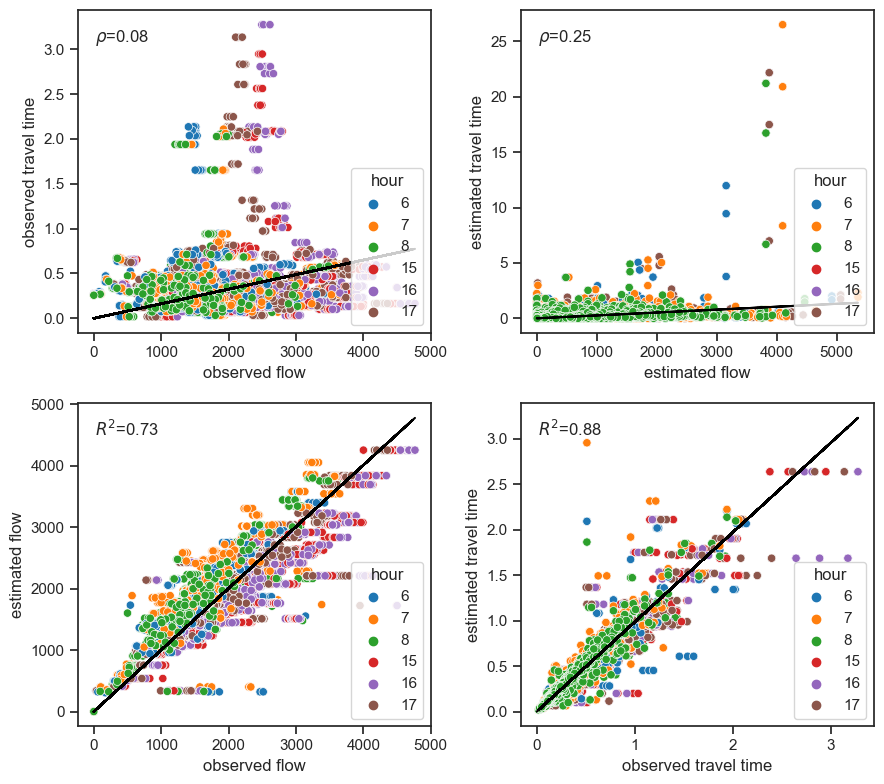

In [72]:
fig, axs = plot_flow_vs_traveltime(model = inference_model,
                        observed_traveltime=inference_model.mask_observed_traveltime(YT_val[:, :, 0]),
                        observed_flow= inference_model.mask_observed_flow(YT_val[:,:,1]),
                        period_col = pd.DataFrame({'period': list(XT_val[:, :, -1].numpy().astype(int).flatten())})['period'].map(dict(zip(period_keys.period_id, period_keys.hour))).values.flatten(),
                        hour_label=True,
                        all_metrics = False
                        )

for ax in axs.reshape(-1):
    ax.legend(loc='lower right', title = 'hour')

plt.savefig('output/figures/results/fresno-scatter-flow-traveltime-outofsample-tvgodlulpe-with-equilibrium.png')

plt.show()

## Write predictions

In [73]:
# Remember to mask observed travel time and observed flow

predictions = pd.DataFrame({'link_key': list(fresno_network.links_keys) * Y_train.shape[0],
                            'observed_traveltime': Y_train[:, :, 0].numpy().flatten(),
                            'observed_flow': Y_train[:, :, 1].numpy().flatten()})

predictions['date'] = sorted(df[df.hour == 16].loc[df[df.hour == 16].year == 2019, 'date'])

# # TODO: Write predictions for TVODLULPE model
# for model in [lue,odlue,odlulpe]:
#
#     predicted_flows = model.flows()
#     predicted_traveltimes = model.traveltimes()
#
#     predictions['predicted_traveltime_' + model.key] = np.tile(predicted_traveltimes, (Y_train.shape[0], 1)).flatten()
#     predictions['predicted_flow_' + model.key] = np.tile(predicted_flows, (Y_train.shape[0], 1)).flatten()
#
# predictions.to_csv(f"./output/tables/{datetime.now().strftime('%y%m%d%H%M%S')}_train_predictions_{fresno_network.key}.csv", index=False)

## K-Fold Cross Validation

In [74]:
models_kfold = {}
metrics_kfold_df = {}
parameters_kfold_df = {}

### - TVODLULPE

In [75]:
n_periods = len(np.unique(XT_train[:, :, -1].numpy().flatten()))

In [76]:
models_kfold['tvodlulpe'], _ = create_tvgodlulpe_model_fresno(
    n_periods= n_periods, network = fresno_network,
    performance_function = create_bpr(network = fresno_network, dtype = _DTYPE),
    od_parameters = ODParameters(key='od',
                                 #initial_values= generation_factors.values[:,np.newaxis]*tntp_network.q.flatten(),
                                 initial_values = tf.stack(q_historic),
                                 # historic_values={10: q_historic[0].flatten()},
                                 ods=fresno_network.ods,
                                 n_periods=n_periods,
                                 time_varying=True,
                                 trainable=True),
    generation = False,
    utility_trainable = True
)

models_kfold['tvodlulpe'].build()

# Prevent to repretrain generation weights
#models_kfold['tvodlulpe'].generation._pretrain_generation_weights = False

In [77]:
# # Use pretrained weights
models_kfold['tvodlulpe'].load_weights(models['tvodlulpe']._filepath_weights)
# model_kfold.load_weights("output/models/230616010949_tvgodlulpe_fresno.h5")
# model_kfold.load_weights("output/models/230616191846_tvgodlulpe_fresno.h5")

In [78]:
# Assumed there is access to reference OD matrix
# q_reference = models['tvgodlulpe'].q
q_reference = models_kfold['tvodlulpe'].q

q_reference

<tf.Tensor: shape=(6, 6970), dtype=float32, numpy=
array([[ 0.1554,  0.    ,  2.5796, ...,  0.    ,  0.    ,  0.    ],
       [ 0.0606,  0.    ,  0.068 , ...,  0.    ,  0.    ,  0.    ],
       [ 0.3082,  0.    ,  0.4053, ...,  0.    ,  0.    ,  0.    ],
       [ 0.0113,  0.    ,  0.0259, ...,  0.    ,  0.    ,  0.1036],
       [ 0.5811,  0.    ,  0.    , ...,  0.    ,  0.    , 24.5193],
       [ 0.0001,  0.    ,  0.0011, ...,  0.    ,  0.    ,  0.0135]],
      dtype=float32)>

In [79]:
# Add historic OD from estimation in 2019
models_kfold['tvodlulpe'].od.historic_values = q_reference

In [80]:
# Add deviation respect to historic OD matrix for better generalization.
_LOSS_WEIGHTS_KFOLD ={'od': 1, 'traveltime': 1, 'flow': 1, 'equilibrium': 1}

In [81]:
metrics_kfold_df['tvodlulpe'], parameters_kfold_df['tvodlulpe'] = train_kfold(
    n_splits=10,
    random_state = _SEED,
    model = models_kfold['tvodlulpe'],
    X = XT_val, Y = YT_val,
    optimizers= {'learning': tf.keras.optimizers.legacy.Adam(learning_rate=_LR['learning']),
                 'equilibrium': tf.keras.optimizers.legacy.Adam(learning_rate=_LR['equilibrium'])
                 },
    node_data = node_data,
    loss_weights=_LOSS_WEIGHTS_KFOLD,
    loss_metric=_LOSS_METRIC,
    equilibrium_stage=_EQUILIBRIUM_STAGE,
    pretrain_link_flows = False,
    # threshold_relative_gap= 5e-2,
    threshold_relative_gap= _RELATIVE_GAP,
    batch_size=1,
    epochs = _EPOCHS,
    # epochs={'learning': 30, 'equilibrium': 10},
    # batch_size=None,
    # epochs={'learning': 3, 'equilibrium': 5}
    # epochs_print_interval= {'learning': 100, 'equilibrium': 100},
    # epochs= {'learning': 4, 'equilibrium': 5}
)

2023-06-29 21:37:35.330839: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz



Fold 1/10

Model training
Benchmark metrics using mean in training data to make predictions in the validation set: 


    component   value metric
0        flow      25   mape
1  traveltime      83   mape
0        flow 6.1e+05    mse
1  traveltime   0.051    mse
0        flow   -0.15     r2
1  traveltime -0.0018     r2

hyperparameters loss function: {'od': 1, 'traveltime': 1, 'flow': 1, 'equilibrium': 1}

number of periods: 6, batch size: 1, threshold relative gap: 0.05
training set -> timepoints: 78, obs [t x]: [1303.  125.], coverage [t x]: [0.54 0.05]
validation set -> timepoints: 78, obs [t x]: [139.  15.], coverage [t x]: [0.06 0.01]

Learning stage: 30 epochs

0/60: train mse=4.7e+04, train mse traveltime=0.0053, train mape traveltime=10.4 train mse flow=1.4e+05, train mape flow=19.1, val mse=4.1e+04, val mse traveltime=0.0053, val mape traveltime=10.1 val mse flow=1.2e+05, val mape flow=14.3, theta = [-2.773 -2.986  0.    -4.76  -0.085 -4.531], avg rr = 1.08, avg theta fixed e

In [82]:
metrics_kfold_df['tvodlulpe'].to_csv(f"./output/experiments/{datetime.now().strftime('%y%m%d%H%M%S')}_kfold_{fresno_network.key}.csv")

# TODO: Add coefficient of variation and save experiments results, compute percentage reduction between final and initial
with pd.option_context('display.float_format', '{:0.3g}'.format):
    print(metrics_kfold_df['tvodlulpe'][metrics_kfold_df['tvodlulpe'].component.isin(['flow','traveltime'])].\
          groupby(['dataset', 'component', 'metric', 'stage'])['value'].\
          aggregate(['median', 'mean', 'std']))

                                          median      mean      std
dataset    component  metric stage                                 
training   flow       mape   benchmark      50.8      49.9      2.9
                             final            10      9.75     1.15
                             initial        19.6      19.4    0.486
                      mse    benchmark  5.86e+05   5.9e+05 1.91e+04
                             final      4.66e+04  4.63e+04 3.33e+03
                             initial    1.56e+05  1.56e+05 4.28e+03
                      r2     benchmark -3.98e-11  3.32e-10 1.74e-08
                             final         0.922     0.922  0.00478
                             initial       0.734     0.736  0.00789
           traveltime mape   benchmark      83.9      83.5     1.38
                             final           5.1      5.12    0.116
                             initial        10.7      10.7   0.0915
                      mse    benchmark    0.0619

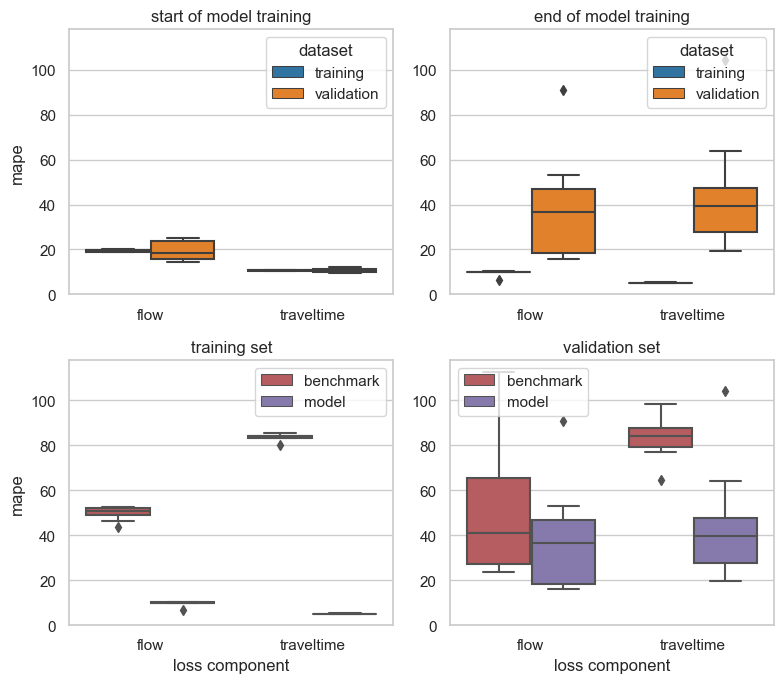

In [83]:
fig, axs = plot_metrics_kfold(df = metrics_kfold_df['tvodlulpe'][metrics_kfold_df['tvodlulpe'].component.isin(['flow','traveltime'])], metric_name = 'mape', showfliers = True)

for ax in axs.reshape(-1):
    ax.set_ylim(bottom = 0)

plt.savefig('output/figures/results/fresno-kfold-mape-tvodlulpe.png')

plt.show()

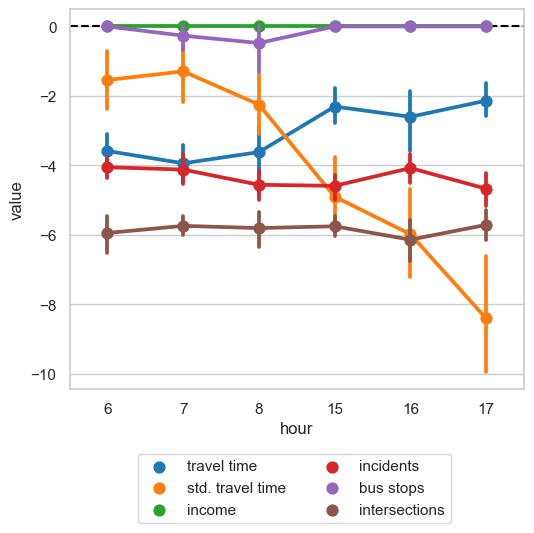

In [84]:
parameters_kfold_df['tvodlulpe']['hour'] = parameters_kfold_df['tvodlulpe'].period.replace({v: k for k, v in models_kfold['tvodlulpe'].period_dict.items()}). \
    replace(dict(zip(period_keys.period_id, period_keys.hour)))

parameters_kfold_df['tvodlulpe']['parameter'] = parameters_kfold_df['tvodlulpe']['parameter'].\
    replace({'tt': 'travel time', 'median_inc': 'income', 'tt_sd': 'std. travel time', 'bus_stops': 'bus stops', 'vot': 'reliability ratio'})

parameters_kfold_df['tvodlulpe']['hour'] \
    = parameters_kfold_df['tvodlulpe']['period'].map({v:period_keys[period_keys.period_id == k]['hour'].iloc[0] for k,v in models_kfold['tvodlulpe'].period_dict.items()})

parameters_kfold_df['tvodlulpe'] = parameters_kfold_df['tvodlulpe'][parameters_kfold_df['tvodlulpe'].parameter != 'reliability ratio']

fig, axs = plot_parameters_kfold(df = parameters_kfold_df['tvodlulpe'][parameters_kfold_df['tvodlulpe'].group == 'utility'], n_cols_legend = 2, figsize = (5.5,5.5), hour_label = True)

plt.axhline(0, linestyle ='dashed', color = 'black')

plt.savefig('output/figures/results/fresno-kfold-utility-periods-tvodlulpe.png')

plt.show()

### - TVGODLULPE

In [85]:
n_periods = len(np.unique(XT_train[:, :, -1].numpy().flatten()))

In [89]:
models_kfold['tvgodlulpe'], _ = create_tvgodlulpe_model_fresno(
    n_periods = n_periods,
    network = fresno_network,
    performance_function = create_mlp(network = fresno_network,
                                      poly_order = 4, pretrain = False, link_specific = False),
    historic_g= generated_trips,
    generation = True,
    generation_trainable = True,
    utility_trainable = True)

models_kfold['tvgodlulpe'].build()

# Prevent to repretrain generation weights
models_kfold['tvgodlulpe'].generation._pretrain_generation_weights = False

In [90]:
# # Use pretrained weights
models_kfold['tvgodlulpe'].load_weights(models['tvgodlulpe']._filepath_weights)
# model_kfold.load_weights("output/models/230616010949_tvgodlulpe_fresno.h5")
# model_kfold.load_weights("output/models/230616191846_tvgodlulpe_fresno.h5")

In [91]:
# Assumed there is access to reference OD matrix
# q_reference = models['tvgodlulpe'].q
q_reference = models_kfold['tvgodlulpe'].q

q_reference

<tf.Tensor: shape=(6, 6970), dtype=float32, numpy=
array([[0.1729, 0.3161, 0.3181, ..., 0.01  , 0.0101, 0.0097],
       [0.0204, 0.1287, 0.0296, ..., 0.007 , 0.007 , 0.0057],
       [0.1237, 0.2978, 0.3804, ..., 0.0092, 0.0091, 0.0109],
       [0.0279, 0.0777, 0.0879, ..., 0.0149, 0.0149, 0.0111],
       [0.1076, 0.1577, 0.5567, ..., 0.0197, 0.0199, 0.0205],
       [0.4714, 0.044 , 0.1033, ..., 0.0059, 0.007 , 0.0082]],
      dtype=float32)>

In [92]:
# Add historic OD from estimation in 2019
models_kfold['tvgodlulpe'].od.historic_values = q_reference

In [93]:
# Add deviation respect to historic OD matrix for better generalization.
_LOSS_WEIGHTS_KFOLD ={'od': 1, 'traveltime': 1, 'flow': 1, 'equilibrium': 1}

In [94]:
metrics_kfold_df['tvgodlulpe'], parameters_kfold_df['tvgodlulpe'] = train_kfold(
    n_splits=10,
    random_state = _SEED,
    model = models_kfold['tvgodlulpe'],
    X = XT_val, Y = YT_val,
    optimizers= {'learning': tf.keras.optimizers.legacy.Adam(learning_rate=_LR['learning']),
                 'equilibrium': tf.keras.optimizers.legacy.Adam(learning_rate=_LR['equilibrium'])
                 },
    node_data = node_data,
    loss_weights=_LOSS_WEIGHTS_KFOLD,
    loss_metric=_LOSS_METRIC,
    equilibrium_stage=_EQUILIBRIUM_STAGE,
    pretrain_link_flows = False,
    # threshold_relative_gap= 5e-2,
    threshold_relative_gap= _RELATIVE_GAP,
    batch_size=1,
    epochs = _EPOCHS,
    # epochs={'learning': 30, 'equilibrium': 10},
    # batch_size=None,
    # epochs={'learning': 3, 'equilibrium': 5}
    # epochs_print_interval= {'learning': 100, 'equilibrium': 100},
    # epochs= {'learning': 4, 'equilibrium': 5}
)


Fold 1/10

Model training
Benchmark metrics using mean in training data to make predictions in the validation set: 


    component   value metric
0        flow      25   mape
1  traveltime      83   mape
0        flow 6.1e+05    mse
1  traveltime   0.051    mse
0        flow   -0.15     r2
1  traveltime -0.0018     r2

hyperparameters loss function: {'od': 1, 'traveltime': 1, 'flow': 1, 'equilibrium': 1}

number of periods: 6, batch size: 1, threshold relative gap: 0.05
training set -> timepoints: 78, obs [t x]: [1303.  125.], coverage [t x]: [0.54 0.05]
validation set -> timepoints: 78, obs [t x]: [139.  15.], coverage [t x]: [0.06 0.01]

Learning stage: 30 epochs

0/60: train mse=4.5e+04, train mse traveltime=0.0078, train mape traveltime=12.1 train mse flow=1.4e+05, train mape flow=19.1, val mse=4e+04, val mse traveltime=0.0075, val mape traveltime=11.4 val mse flow=1.2e+05, val mape flow=14.7, theta = [-3.666 -3.636  0.    -5.59   0.    -5.333], avg rr = 0.99, avg theta fixed eff

In [95]:
metrics_kfold_df['tvgodlulpe'].to_csv(f"./output/experiments/{datetime.now().strftime('%y%m%d%H%M%S')}_kfold_{fresno_network.key}.csv")

# TODO: Add coefficient of variation and save experiments results, compute percentage reduction between final and initial
with pd.option_context('display.float_format', '{:0.3g}'.format):
    print(metrics_kfold_df['tvgodlulpe'][metrics_kfold_df['tvgodlulpe'].component.isin(['flow','traveltime'])].\
          groupby(['dataset', 'component', 'metric', 'stage'])['value'].\
          aggregate(['median', 'mean', 'std']))

                                          median      mean      std
dataset    component  metric stage                                 
training   flow       mape   benchmark      50.8      49.9      2.9
                             final          10.4        10     1.13
                             initial        19.6      19.5     0.49
                      mse    benchmark  5.86e+05   5.9e+05 1.91e+04
                             final      5.02e+04  4.96e+04 3.42e+03
                             initial    1.58e+05  1.58e+05 3.96e+03
                      r2     benchmark -3.98e-11  3.32e-10 1.74e-08
                             final         0.915     0.916  0.00543
                             initial       0.731     0.733  0.00748
           traveltime mape   benchmark      83.9      83.5     1.38
                             final          9.63      9.67    0.241
                             initial        12.2      12.2     0.13
                      mse    benchmark    0.0619

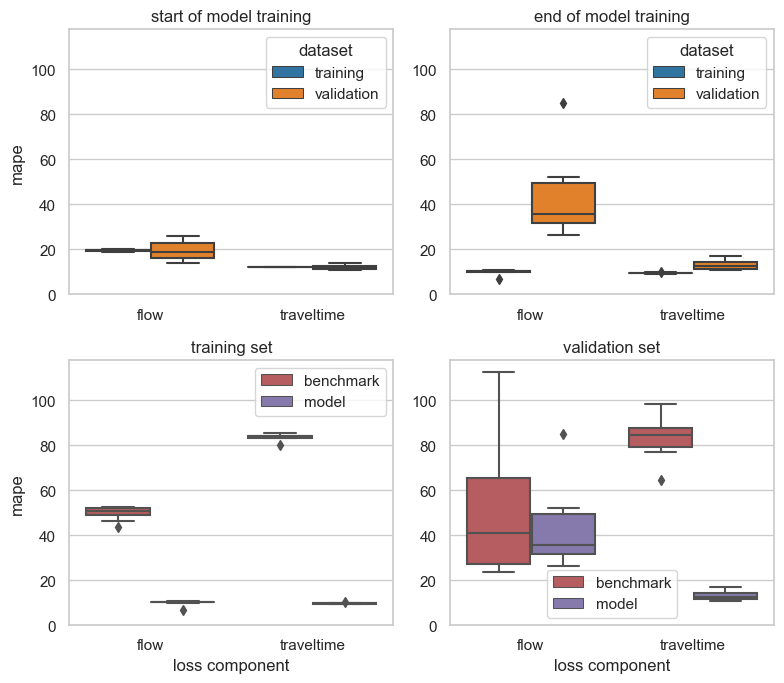

In [96]:
fig, axs = plot_metrics_kfold(df = metrics_kfold_df['tvgodlulpe'][metrics_kfold_df['tvgodlulpe'].component.isin(['flow','traveltime'])], metric_name = 'mape', showfliers = True)

for ax in axs.reshape(-1):
    ax.set_ylim(bottom = 0)

plt.savefig('output/figures/results/fresno-kfold-mape-tvgodlulpe.png')

plt.show()

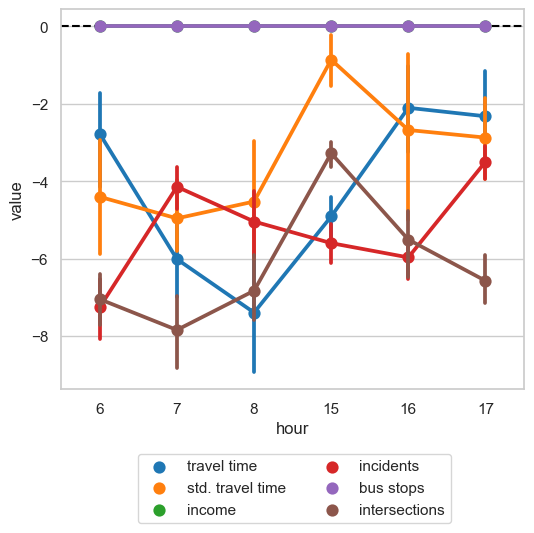

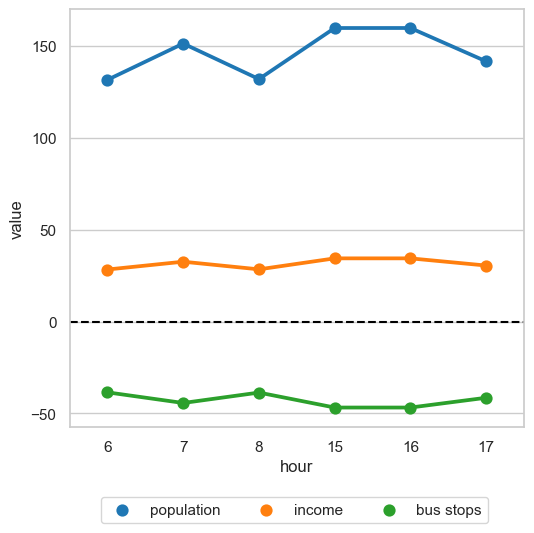

In [97]:
parameters_kfold_df['tvgodlulpe']['hour'] = parameters_kfold_df['tvgodlulpe'].period.replace({v: k for k, v in models_kfold['tvgodlulpe'].period_dict.items()}). \
    replace(dict(zip(period_keys.period_id, period_keys.hour)))

parameters_kfold_df['tvgodlulpe']['parameter'] = parameters_kfold_df['tvgodlulpe']['parameter'].\
    replace({'tt': 'travel time', 'median_inc': 'income', 'tt_sd': 'std. travel time', 'bus_stops': 'bus stops', 'vot': 'reliability ratio'})

parameters_kfold_df['tvgodlulpe']['hour'] \
    = parameters_kfold_df['tvgodlulpe']['period'].map({v:period_keys[period_keys.period_id == k]['hour'].iloc[0] for k,v in models_kfold['tvgodlulpe'].period_dict.items()})

parameters_kfold_df['tvgodlulpe'] = parameters_kfold_df['tvgodlulpe'][parameters_kfold_df['tvgodlulpe'].parameter != 'reliability ratio']

fig, axs = plot_parameters_kfold(df = parameters_kfold_df['tvgodlulpe'][parameters_kfold_df['tvgodlulpe'].group == 'utility'], n_cols_legend = 2, figsize = (5.5,5.5), hour_label = True)

plt.axhline(0, linestyle ='dashed', color = 'black')

plt.savefig('output/figures/results/fresno-kfold-utility-periods-tvgodlulpe.png')

plt.show()

fig, axs = plot_parameters_kfold(df = parameters_kfold_df['tvgodlulpe'][parameters_kfold_df['tvgodlulpe'].group == 'generation'], n_cols_legend = 3, figsize = (5.5,5.5), hour_label = True)

plt.axhline(0, linestyle ='dashed', color = 'black')

plt.savefig('output/figures/results/fresno-kfold-generation-periods-tvgodlulpe.png')

plt.show()

## Write estimation results

In [98]:
train_results_df, val_results_df \
    = map(lambda x: pd.concat([results.assign(model = model)[['model'] + list(results.columns)]
                               for model, results in x.items()],axis = 0), [train_results_dfs, val_results_dfs])

train_filename = f"{datetime.now().strftime('%y%m%d%H%M%S')}_train_results_{fresno_network.key}.csv"
val_filename = f"{datetime.now().strftime('%y%m%d%H%M%S')}_validation_results_{fresno_network.key}.csv"
train_results_df.to_csv(f"./output/tables/{train_filename}")
print(f'File {train_filename} was written')
val_results_df.to_csv(f"./output/tables/{val_filename}")
print(f'File {val_filename} was written')

File 230630223059_train_results_fresno.csv was written
File 230630223059_validation_results_fresno.csv was written


## Summary of parameter estimates

### All models

In [99]:
models

{'tvodlulpe': <nesuelogit.models.NESUELOGIT at 0x28c319d90>,
 'tvgodlulpe': <nesuelogit.models.NESUELOGIT at 0x3112dd940>}

In [100]:
results = pd.DataFrame({'parameter': [], 'model': []})

for model_key, model in models.items():
    model_results = {**dict(zip(['tt'] + _FEATURES_Z, list(np.mean(model.theta.numpy(), axis=0)))),
                     **{'rr': float(model.get_parameters_estimates().eval('tt_sd/tt').iloc[0]),
                        'fixed_effect_mean': np.mean(model.fixed_effect),
                        'fixed_effect_std': np.std(model.fixed_effect),
                        'od_mean': np.mean(model.q),
                        'od_std': np.std(model.q)
                        }}

    if model.performance_function.type == 'bpr':
        model_results = {**model_results, **{'alpha_mean': np.mean(model.performance_function.alpha),
                                             'alpha_std': np.std(model.performance_function.alpha),
                                             'beta_mean': np.mean(model.performance_function.beta),
                                             'beta_std': np.std(model.performance_function.beta)}}

    model_results = pd.DataFrame({'parameter': model_results.keys(), 'values': model_results.values()}). \
        assign(model=model_key)

    results = pd.concat([results, model_results])

In [101]:
print(results.pivot_table(index = ['parameter'], columns = 'model', values = 'values', sort=False).round(4))

model              tvodlulpe  tvgodlulpe
parameter                               
tt                   -2.7729     -3.6659
tt_sd                -2.9856     -3.6364
median_inc            0.0000      0.0000
incidents            -4.7602     -5.5902
bus_stops            -0.0852      0.0000
intersections        -4.5305     -5.3334
rr                    1.0767      0.9919
fixed_effect_mean    -0.0486     -0.0672
fixed_effect_std      0.6808      1.9818
od_mean              10.0725     10.4217
od_std               41.8084     43.7755
alpha_mean            0.8933         NaN
alpha_std             1.1661         NaN
beta_mean             3.7247         NaN
beta_std              2.6876         NaN


### TVGODLULPE

In [102]:
# Stats by period
model = models['tvgodlulpe']

with pd.option_context('display.float_format', '{:0.4f}'.format):
    print('theta:', pd.DataFrame(model.theta.numpy().T))

theta:         0       1       2       3       4       5
0 -2.6995 -4.8370 -5.2409 -3.1575 -2.7330 -3.3277
1 -3.3040 -4.2951 -0.6050 -3.8373 -3.8535 -5.9233
2  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
3 -5.8718 -4.5149 -4.3958 -7.8621 -6.2816 -4.6149
4  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
5 -5.1047 -6.2304 -4.3475 -3.9269 -4.6268 -7.7641


In [103]:
with pd.option_context('display.float_format', '{:0.4f}'.format):
    print('kappa:', pd.DataFrame(model.kappa.numpy().T))

kappa:          0        1        2        3        4        5
0 131.4958 151.2198 131.8887 159.6779 159.6841 141.5333
1  28.2930  32.5369  28.3776  34.3568  34.3581  30.4527
2 -38.5438 -44.3253 -38.6590 -46.8045 -46.8064 -41.4860


In [104]:
# with pd.option_context('display.float_format', '{:0.1f}'.format):
with pd.option_context('display.float_format', '{:0.4f}'.format):
    print('OD matrix', pd.DataFrame({'od_mean': np.mean(model.q,axis = 1), 'od_std': np.std(model.q, axis = 1), 'od_total':np.sum(model.q,axis = 1)}).T)

OD matrix                   0          1          2          3          4          5
od_mean      9.3902    10.7951     9.4283    11.4049    11.4198    10.0921
od_std      39.0473    47.5125    37.1713    45.7377    43.4963    48.4333
od_total 65449.7422 75241.8594 65715.5781 79492.3125 79595.8906 70341.7656


## Summary of models goodness of fit

In [105]:
results_losses = pd.DataFrame({})
loss_columns = ['loss_flow', 'loss_traveltime', 'loss_equilibrium', 'loss_total']

for model_key, model in models.items():
    results_losses_model = model.split_results(train_results_dfs[model_key])[1].assign(model=model_key)
    results_losses_model = results_losses_model[results_losses_model.epoch == _EPOCHS['learning']].iloc[[0]]
    results_losses = pd.concat([results_losses, results_losses_model])

results_losses[loss_columns] = (results_losses[loss_columns] - 1) * 100

In [106]:
with pd.option_context('display.float_format', '{:0.4f}'.format):
    print(results_losses[['model'] + list(results_losses.columns)])

         model  epoch  loss_traveltime              loss_od  loss_theta   
30   tvodlulpe     30         -99.9198 249425222410206.7500         NaN  \
30  tvgodlulpe     30         -99.9988               1.7592         NaN   

    loss_flow  loss_equilibrium  loss_bpr  loss_ntrips         loss_prop_od   
30   -96.8687          254.3360       NaN          NaN 201097927248363.9375  \
30   -98.8978           54.2194       NaN          NaN               1.5363   

    loss_mlp_regularizer  loss_total  relative_gap       model  
30                   NaN    -96.2835        0.0345   tvodlulpe  
30                   NaN    -98.3332        0.0388  tvgodlulpe  


## Plot of convergence toward true rr across models

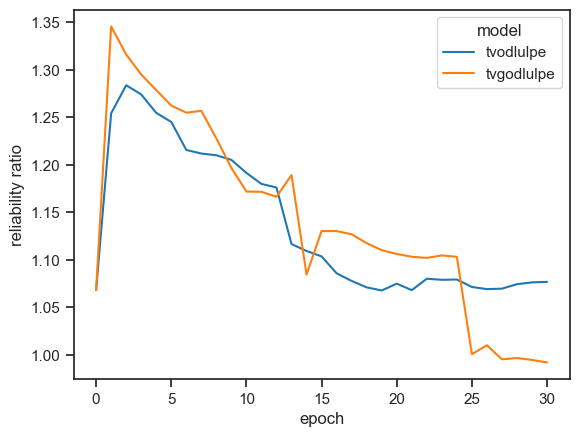

In [107]:
train_estimates = {}
train_losses = {}

for model_key, model in models.items():
    train_estimates[model_key], train_losses[model_key] = model.split_results(results=train_results_dfs[model_key])

    train_estimates[model_key]['model'] = model_key

train_estimates_df = pd.concat(train_estimates.values())

train_estimates_df['rr'] = train_estimates_df['tt_sd'] / train_estimates_df['tt']

estimates = train_estimates_df[['epoch', 'model', 'rr']].reset_index().drop('index', axis=1)
#estimates = estimates[estimates.epoch != 0]

fig, ax = plt.subplots(nrows=1, ncols=1)

g = sns.lineplot(data=estimates, x='epoch', hue='model', y='rr')

# ax.hlines(y=compute_rr(models.popitem().true_values), xmin=estimates['epoch'].min(), xmax=estimates['epoch'].max(), linestyle='--', label = 'truth')

ax.set_ylabel('reliability ratio')

ax.set_xticks(np.arange(estimates['epoch'].min(), estimates['epoch'].max() + 2, _XTICKS_SPACING))

#ax.set_yscale('log')
#plt.ylim(ymin=0)
plt.show()

## Plot of reliability ratio by hour for all models

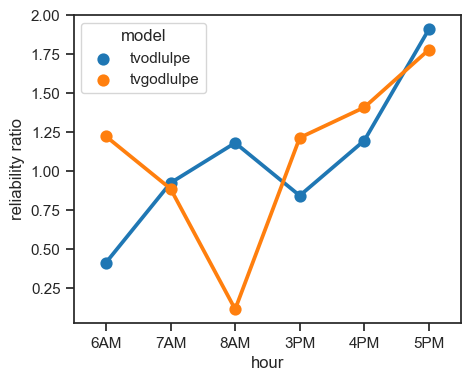

In [108]:
reliability_ratios = plot_rr_by_period_models(models, period_keys, period_feature='hour', join = True)

plt.savefig('output/figures/results/fresno-reliability-ratios-periods.png')

plt.show()

In [109]:
print(reliability_ratios)

         rr  hour hour_id       model
0  0.414526     6     6AM   tvodlulpe
0  1.223908     6     6AM  tvgodlulpe
1  0.925700     7     7AM   tvodlulpe
1  0.887968     7     7AM  tvgodlulpe
2  1.182251     8     8AM   tvodlulpe
2  0.115438     8     8AM  tvgodlulpe
3  0.843910    15     3PM   tvodlulpe
3  1.215280    15     3PM  tvgodlulpe
4  1.197421    16     4PM   tvodlulpe
4  1.410003    16     4PM  tvgodlulpe
5  1.910804    17     5PM   tvodlulpe
5  1.779994    17     5PM  tvgodlulpe


In [110]:
with pd.option_context('display.float_format', '{:0.4f}'.format):
    print(reliability_ratios[reliability_ratios.model == 'tvgodlulpe'][['hour','rr']].T)

          0      1      2       3       4       5
hour 6.0000 7.0000 8.0000 15.0000 16.0000 17.0000
rr   1.2239 0.8880 0.1154  1.2153  1.4100  1.7800


In [111]:
print(reliability_ratios.groupby('model')[['rr']].mean().round(4))

                rr
model             
tvgodlulpe  1.1054
tvodlulpe   1.0791


## Plot of total trips by hour for all models

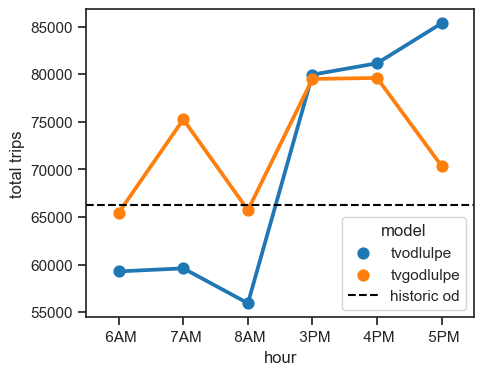

In [112]:
total_trips = plot_total_trips_models(models = models, period_feature = 'hour', period_keys = period_keys,
                                      historic_od = fresno_network.q.flatten(), join = True)

plt.savefig('output/figures/results/fresno-total-trips-periods.png')

plt.show()

In [113]:
print(total_trips)

   hour   total_trips       model  order
0   6AM  59276.531250   tvodlulpe      6
0   6AM  65449.585938  tvgodlulpe      6
1   7AM  59599.640625   tvodlulpe      7
1   7AM  75241.992188  tvgodlulpe      7
2   8AM  55932.910156   tvodlulpe      8
2   8AM  65715.554688  tvgodlulpe      8
3   3PM  79944.125000   tvodlulpe     15
3   3PM  79492.187500  tvgodlulpe     15
4   4PM  81137.820312   tvodlulpe     16
4   4PM  79595.929688  tvgodlulpe     16
5   5PM  85341.507812   tvodlulpe     17
5   5PM  70341.843750  tvgodlulpe     17


In [114]:
total_trips.groupby('model')[['total_trips']].mean().round(1)

total_trips
model                   
tvgodlulpe  72639.500000
tvodlulpe   70205.398438

In [115]:
total_trips.groupby('model')[['total_trips']].sum().round(1)

total_trips
model                   
tvgodlulpe  435837.09375
tvodlulpe   421232.59375



## Global runtime

In [116]:
print(f'runtime: {time.time()-t0_global:0.1f} [s]')

runtime: 98526.9 [s]
